## Load Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler

moss_green_qualitative = [
    "#2F5D50", "#4F7F6A", "#6B8F71", "#8FAF9A",
    "#A8C3A0", "#5B6F4E", "#7A8C61", "#9BB28A",
]
moss_green_dark = ["#1F3F36", "#2F5D50", "#3E6F5C", "#4F7F6A", "#5B6F4E"]
moss_qualitative_dark = [
    "#1F3F36",  # dark moss
    "#4A6C8C",  # slate blue
    "#5B6F4E",  # olive bark
    "#7A5C61",  # muted clay
    "#3F5F5B",  # dark teal
]

moss_cmap = ListedColormap(moss_green_qualitative, name="moss_green_qualitative")
moss_cmap_dark = ListedColormap(moss_qualitative_dark, name="moss_qualitative_dark")

# Register (force=True avoids “already registered” errors in notebooks)
mpl.colormaps.register(moss_cmap, force=True)
mpl.colormaps.register(moss_cmap_dark, force=True)

# ---- Style settings (Nature-like) ----
plt.rcParams.update({
    # Text fonts
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    # Math fonts
    "mathtext.fontset": "stix",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",

    # Sizes
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # Style
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",

    # Color
    "axes.prop_cycle": cycler(color=moss_qualitative_dark),
})

In [ ]:
# Get original model activations and weights
activations = torch.load("final_result/flux.1-schnell-activations.pt", weights_only=False)
weights = torch.load("final_result/flux.1-schnell-weights.pt", weights_only=False)

In [ ]:
def parse_activations(cache):
    data = {}
    for name, act in cache.items():
        act = act[-1]
        # print("Length of activations for layer", name, ":", len(act))
        layer_name = ".".join(name.split(".")[:-1])
        is_input = name.endswith(".input")
        mode = "input_acts" if is_input else "output_acts"
        if layer_name not in data:
            data[layer_name] = {
                "MJHQ" : {
                    t : {"input_acts" : [], "output_acts" : []} for t in range(4)
                },
                "sDCI" : {
                    t : {"input_acts" : [], "output_acts" : []} for t in range(4)
                }
            }
        for i, item in enumerate(act):
            if i < 64:
                dataset = "MJHQ"
            else:
                dataset = "sDCI"
            t = i % 4
            data[layer_name][dataset][t][mode].append(item)
    return data

In [ ]:
# Select a layer
dataset = "MJHQ" # MJHQ or sDCI
ts = 0
# layer_name = 'transformer_blocks.11.attn.to_q'
layer_name = 'transformer_blocks.11.ff.net.0.proj'
w = weights[layer_name]['weight']
x = parse_activations(activations)[layer_name][dataset][ts]['input_acts']
x = torch.cat(x, dim=0)

In [ ]:
print("Shape of input activations:", x.shape)
print("Shape of weights:", w.shape)

### Utils

In [ ]:
# RTN

def rtn_absmax(x: torch.Tensor, bits: int = 4, block_size: int = 16, debug_group: bool = False) -> torch.Tensor:
    qmin = -(2 ** (bits - 1)) + 1
    qmax = (2 ** (bits - 1)) - 1

    org_shape = x.shape
    x = x.reshape(-1)
    n = x.numel()
    
    r = n % block_size
    if r != 0:
        pad = block_size - r
        x_pad = torch.empty(n + pad, device=x.device, dtype=x.dtype)
        x_pad[:n].copy_(x)
        x_pad[n:].zero_()
        x = x_pad
    
    xb = x.view(-1, block_size)

    if debug_group:
        print("RTN AbsMax Debug Info:")
        print("- Number of groups:", x.shape[0])
        debug_data = {
            "per_group_var" : xb.var(dim=1),
            "per_group_max" : xb.amax(dim=1),
            "per_group_min" : xb.amin(dim=1),
            "per_group_mean" : xb.mean(dim=1),
        }
    

    absmax = x.abs().amax(dim=-1, keepdim=True)
    scale = absmax / qmax
    scale[scale == 0] = 1e-8  # Prevent division by zero

    q = torch.round(x / scale).clamp(qmin, qmax)
    deq = q * scale

    if debug_group:
        debug_data["per_group_quant_error"] = torch.norm(xb - deq.view(-1, block_size), dim=-1, p='fro')

    deq = deq.view(-1)[:n].view(org_shape).to(x.dtype)
    if debug_group:
        return deq, debug_data
    return deq

def rtn_minmax(x: torch.Tensor, bits: int = 4, block_size: int = 16, debug_group: bool = False) -> torch.Tensor:
    qmin = -(2 ** (bits - 1)) + 1
    qmax = (2 ** (bits - 1)) - 1

    org_shape = x.shape
    x = x.reshape(-1)
    n = x.numel()
    
    r = n % block_size
    if r != 0:
        pad = block_size - r
        x_pad = torch.empty(n + pad, device=x.device, dtype=x.dtype)
        x_pad[:n].copy_(x)
        x_pad[n:].zero_()
        x = x_pad
    
    xb = x.view(-1, block_size)

    if debug_group:
        print("RTN MinMax Debug Info:")
        print("- Number of groups:", x.shape[0])
        debug_data = {
            "per_group_var" : xb.var(dim=1),
            "per_group_max" : xb.amax(dim=1),
            "per_group_min" : xb.amin(dim=1),
            "per_group_mean" : xb.mean(dim=1),
        }

    _max = x.amax(dim=-1, keepdim=True)
    _min = x.amin(dim=-1, keepdim=True)
    scale = (_max - _min) / (2 ** bits - 1)
    scale[scale == 0] = 1e-8  # Prevent division by zero
    zero_point = (_max + _min) / (2.0 * scale)

    q = torch.round(xb / scale - zero_point).clamp_(qmin, qmax)
    deq = (q + zero_point) * scale

    if debug_group:
        debug_data["per_group_quant_error"] = torch.norm(xb - deq.view(-1, block_size), dim=-1, p='fro')

    deq = deq.view(-1)[:n].view(org_shape).to(x.dtype)
    if debug_group:
        return deq, debug_data
    return deq


def rtn_minmax_zp(x: torch.Tensor, bits: int = 4, block_size: int = 16, debug_group: bool = False) -> torch.Tensor:
    qmin = -(2 ** (bits - 1)) + 1
    qmax = (2 ** (bits - 1)) - 1

    org_shape = x.shape
    x = x.reshape(-1)
    n = x.numel()
    
    r = n % block_size
    if r != 0:
        pad = block_size - r
        x_pad = torch.empty(n + pad, device=x.device, dtype=x.dtype)
        x_pad[:n].copy_(x)
        x_pad[n:].zero_()
        x = x_pad
    
    xb = x.view(-1, block_size)

    if debug_group:
        print("RTN MinMax Debug Info:")
        print("- Number of groups:", x.shape[0])
        debug_data = {
            "per_group_var" : xb.var(dim=1),
            "per_group_max" : xb.amax(dim=1),
            "per_group_min" : xb.amin(dim=1),
            "per_group_mean" : xb.mean(dim=1),
        }

    _max = x.amax(dim=-1, keepdim=True)
    _min = x.amin(dim=-1, keepdim=True)
    scale = (_max - _min) / (2 ** (bits-1) - 1)
    scale[scale == 0] = 1e-8  # Prevent division by zero
    zero_point = (_max + _min) / (2.0 * scale)

    q = torch.round(xb / scale - zero_point).clamp_(qmin, qmax)
    deq = (q + zero_point) * scale
    
    if debug_group:
        debug_data["per_group_quant_error"] = torch.norm(xb - deq.view(-1, block_size), dim=-1, p='fro')

    deq = deq.view(-1)[:n].view(org_shape).to(x.dtype)
    if debug_group:
        return deq, debug_data
    return deq

In [ ]:
# QuaRTZ
@torch.no_grad()
def lzs(x: torch.Tensor, bits: int = 4) -> torch.Tensor:
    """
    Real per-block LZS (shared flag per block).
    Expects x shaped [..., block_size]. Computes a single flag per block from max MSB in the block.

    For bits=4, we keep a 3-bit mantissa [0..7] and a shared power-of-two shift per block.
    """
    # sign + magnitude
    sign = torch.sign(x)
    a = torch.abs(x).clamp_max_(127)  # keep in INT8-like magnitude range

    # MSB per element using frexp: MSB = exp for a>0 else 0
    _, exp = torch.frexp(a)
    msb = torch.where(a > 0, exp, torch.zeros_like(exp))  # same shape as a

    # Block-wise max MSB (shared across last dim = block_size)
    msb_blk = msb.amax(dim=-1, keepdim=True)

    # Shared FLAG per block: max(MSB) - 3, clamped at 0
    flag = (msb_blk - 3).clamp_min_(0)

    # scale = 2^flag (shared per block)
    scale = torch.ldexp(torch.ones_like(a), flag)

    # quantize each element using shared scale
    q = torch.round(a / scale).clamp_(0, 7) * scale
    return sign * q

@torch.no_grad()
def quartz(
    tensor: torch.Tensor,
    quant_block_size: int = 32,
    lzs_block_size: int = 16,
    mode: str = "mx",
    debug_group: bool = False,
) -> torch.Tensor:
    """
    GPU-efficient QUARTZ-like quantization + LZS + dequant (verification path).
    """
    if tensor.numel() == 0:
        return tensor

    orig_shape = tensor.shape
    device = tensor.device
    dtype = tensor.dtype

    # Flatten
    x = tensor.reshape(-1)

    # Pad to multiple of quant_block_size (avoid torch.cat when possible)
    n = x.numel()
    r = n % quant_block_size
    if r != 0:
        pad = quant_block_size - r
        x_pad = torch.empty(n + pad, device=device, dtype=dtype)
        x_pad[:n].copy_(x)
        x_pad[n:].zero_()
        x = x_pad

    # [num_qblocks, quant_block_size]
    x = x.view(-1, quant_block_size)

    # Per-block scale (keep in FP32 for stability; cast back later)
    x_fp = x.clone().float()

    if debug_group:
        print("QUARTZ Debug Info:")
        print("- Number of groups:", x.shape[0])
        debug_data = {
            "per_group_var" : x_fp.var(dim=1),
            "per_group_max" : x_fp.amax(dim=1),
            "per_group_min" : x_fp.amin(dim=1),
            "per_group_mean" : x_fp.mean(dim=1),
        }

    if mode == "mx":
        scales = torch.amax(x_fp.abs(), dim=1, keepdim=True) / 127.0
    elif mode == "lzs":
        # Your original denominator was (2^(8-2)-1)=63 (effectively 7-bit signed w/ extra headroom)
        scales = (torch.amax(x_fp, dim=1, keepdim=True) - torch.amin(x_fp, dim=1, keepdim=True)) / 128.0
    else:
        raise ValueError(f"Unknown mode {mode} for QUARTZ quantization")

    # Guard against zeros (important for all-zero blocks)
    scales = scales.clamp_min_(1e-12)

    # INT8 quant (kept as float here to match your code path)
    q = torch.round(x_fp / scales).clamp_(-128, 127)

    # LZS over all lzs blocks in one shot
    q = q.view(-1, lzs_block_size)
    q = lzs(q, bits=4)
    q = q.view(-1, quant_block_size)

    # Dequant (verification)
    deq = (q * scales).to(dtype)

    if debug_group:
        debug_data["per_group_quant_error"] = torch.norm(x - deq, dim=-1, p='fro')

    # Unpad back to original length, reshape
    if r != 0:
        deq = deq.view(-1)[:n]
    if debug_group:
        return deq.view(orig_shape), debug_data
    return deq.view(orig_shape)

In [ ]:
# FP4 E2M1 quant/dequant (NVFP4 uses E2M1)   [oai_citation:1‡NVIDIA Developer](https://developer.nvidia.com/blog/introducing-nvfp4-for-efficient-and-accurate-low-precision-inference/)

@torch.no_grad()
def fp4_e2m1_quant_dequant(x: torch.Tensor) -> torch.Tensor:
    """
    Quantize+dequantize to FP4 E2M1 (bias=1) in float, vectorized.
    Representable magnitudes: {0, 0.5, 1, 1.5, 2, 3, 4, 6} (and negatives).
    Saturates to +/-6.
    """
    sign = torch.sign(x)
    a = torch.abs(x)

    # Saturate to max representable magnitude (~6)
    a = a.clamp_max(6.0)

    out = torch.zeros_like(a)

    # Subnormal/zero region: representable are 0 and 0.5
    # Midpoint thresholds: 0.25 between 0 and 0.5, 0.75 between 0.5 and 1.0
    sub = a < 1.0
    out = torch.where(sub & (a >= 0.25) & (a < 0.75), torch.full_like(a, 0.5), out)
    out = torch.where(sub & (a >= 0.75), torch.ones_like(a), out)  # near 1.0 maps to 1.0

    # Normal region (>=1): values are base * {1.0, 1.5}, base in {1,2,4}
    normal = a >= 1.0
    if normal.any():
        # exponent = floor(log2(a)), clamped to [0,2]
        exp = torch.floor(torch.log2(a.clamp_min(1e-30))).to(torch.int32)
        exp = exp.clamp(0, 2)

        base = torch.pow(torch.tensor(2.0, device=a.device, dtype=a.dtype), exp.to(a.dtype))
        mant = a / base  # in [1,2)

        # 1 mantissa bit => choose 1.0 vs 1.5; threshold at midpoint 1.25
        mant_bit = (mant >= 1.25).to(a.dtype)
        val = base * (1.0 + 0.5 * mant_bit)

        out = torch.where(normal, val, out)

    return sign * out


# -----------------------------
# FP8 E4M3 quant/dequant for block scales   [oai_citation:2‡NVIDIA Developer](https://developer.nvidia.com/blog/introducing-nvfp4-for-efficient-and-accurate-low-precision-inference/)
# -----------------------------
@torch.no_grad()
def fp8_e4m3_quant_dequant(x: torch.Tensor) -> torch.Tensor:
    """
    Approximate quant+dequant to FP8 E4M3 in float, vectorized.

    This is an emulation intended for NVFP4 block scales (E4M3). NVFP4 uses
    an FP8 (E4M3) scale per 16-value block and an FP32 per-tensor scale.  [oai_citation:3‡NVIDIA Developer](https://developer.nvidia.com/blog/introducing-nvfp4-for-efficient-and-accurate-low-precision-inference/)

    We clamp to ~448 max magnitude (common E4M3FN max cited in NVFP4 contexts).  [oai_citation:4‡NVIDIA Docs](https://docs.nvidia.com/deeplearning/tensorrt/latest/inference-library/work-quantized-types.html?utm_source=chatgpt.com)
    """
    sign = torch.sign(x)
    a = torch.abs(x)

    # clamp to finite max (commonly cited as 448 for E4M3 scales in NVFP4 tooling)
    a = a.clamp_max(448.0)

    # Handle zeros
    out = torch.zeros_like(a)
    nz = a > 0
    if not nz.any():
        return out

    # E4M3: bias=7, mantissa bits=3
    bias = 7
    m_bits = 3

    # Use frexp for stable exponent/mantissa extraction: a = frac * 2^exp, frac in [0.5,1)
    frac, exp = torch.frexp(a)  # exp is int-like tensor
    # Convert to IEEE-style normalized mantissa in [1,2): mant = 2*frac
    mant = frac * 2.0
    e = exp - 1  # now floor(log2(a))

    # Normal exponent field range for FP8 is limited; emulate a reasonable clamp
    # (This is approximate; NVIDIA uses specific FP8 variants.)
    e_clamped = e.clamp(-6, 8)  # keeps within range that covers up to ~448

    base = torch.ldexp(torch.ones_like(a), e_clamped)  # 2^e
    mant_norm = (a / base)  # ~[1,2)

    # Quantize mantissa to 3 bits: 1.xxx with 3 fractional bits
    mant_q = torch.round((mant_norm - 1.0) * (2**m_bits)) / (2**m_bits) + 1.0

    # Handle rounding overflow (e.g., mant_q becomes 2.0)
    carry = mant_q >= 2.0
    mant_q = torch.where(carry, mant_q * 0.5, mant_q)
    e2 = torch.where(carry, e_clamped + 1, e_clamped)

    # Reconstruct and clamp again
    out_nz = mant_q * torch.ldexp(torch.ones_like(a), e2)
    out_nz = out_nz.clamp_max(448.0)

    out = torch.where(nz, out_nz, out)
    return sign * out


# -----------------------------
# NVFP4-like quantization
# -----------------------------
@torch.no_grad()
def nvfp4(tensor: torch.Tensor, block_size: int = 16, return_meta: bool = False, debug_group: bool = False):
    """
    NVFP4-like quantization (emulated) with:
      Step 1: per-tensor FP32 scale (global_sf)
      Step 2: per-block FP8 E4M3 scale (s_fp8), block_size=16
      Step 3: per-element FP4 E2M1 values (q_fp4)

    Returns dequantized tensor (verification). Optionally returns (global_sf, s_fp8).
    """
    if tensor.numel() == 0:
        return (tensor, None) if return_meta else tensor

    orig_shape = tensor.shape
    x = tensor.reshape(-1).float()
    n = x.numel()

    # Pad to multiple of block_size (avoid torch.cat)
    r = n % block_size
    if r != 0:
        pad = block_size - r
        x_pad = torch.empty(n + pad, device=x.device, dtype=x.dtype)
        x_pad[:n].copy_(x)
        x_pad[n:].zero_()
        x = x_pad

    xb = x.view(-1, block_size)  # [num_blocks, block_size]
    
    if debug_group:
        print("NVFP4 Debug Info:")
        print("- Number of blocks:", xb.shape[0])
        debug_data = {
            "per_group_var" : xb.var(dim=1),
            "per_group_max" : xb.amax(dim=1),
            "per_group_min" : xb.amin(dim=1),
            "per_group_mean" : xb.mean(dim=1),
        }

    # -------------------------
    # Step 1: Per-tensor scaling (FP32)
    # Choose global_sf so that block scales fit FP8 range (~448) with qTypeMax=6
    # TensorRT doc expresses scale_fp8 ~ cast_fp8( amax(block) / (6 * globalSf) ).  [oai_citation:5‡NVIDIA Docs](https://docs.nvidia.com/deeplearning/tensorrt/latest/inference-library/work-quantized-types.html?utm_source=chatgpt.com)
    # So set globalSf = max_block_amax / (6 * 448) to keep inside range.
    # -------------------------
    block_amax = xb.abs().amax(dim=1, keepdim=True)  # [B,1]
    max_block_amax = block_amax.max()
    denom = 6.0 * 448.0
    global_sf = torch.where(max_block_amax > 0, max_block_amax / denom, torch.tensor(1.0, device=x.device))
    global_sf = global_sf.clamp_min(1e-12)

    # -------------------------
    # Step 2: Per-block scaling (FP8 E4M3)
    # Unquantized block scale in "FP8 domain"
    # -------------------------
    s = block_amax / (6.0 * global_sf)  # [B,1], ideally <= 448
    s_fp8 = fp8_e4m3_quant_dequant(s)   # emulate storing scale in FP8 E4M3

    # Avoid divide-by-zero for all-zero blocks
    s_fp8 = s_fp8.clamp_min(1e-12)

    # -------------------------
    # Step 3: Quantize values to FP4 E2M1 under combined scale
    # q_fp4 = cast_fp4( x / (global_sf * s_fp8) )
    # dequant = global_sf * s_fp8 * deq_fp4(q_fp4)
    # -------------------------
    y = xb / (global_sf * s_fp8)
    yq = fp4_e2m1_quant_dequant(y)
    deq = yq * (global_sf * s_fp8)

    if debug_group:
        debug_data["per_group_quant_error"] = torch.norm(xb - deq, dim=1, p='fro')

    # Unpad + reshape
    deq = deq.view(-1)[:n].view(orig_shape).to(tensor.dtype)

    if return_meta:
        # Return dequant + (global_sf scalar, per-block fp8 scale shaped [num_blocks,1])
        return deq, {"global_sf": global_sf.to(tensor.dtype), "block_scales_fp8": s_fp8.to(tensor.dtype)}
    if debug_group:
        return deq, debug_data
    return deq

In [5]:
# Smoothing
@torch.no_grad()
def compute_span_x(x: torch.Tensor, mode: str = "abs_max") -> torch.Tensor:
    # x: (N, C, D) -> (C,)
    if mode == "abs_max":
        return x.abs().amax(dim=(0, 1))
    if mode == "rms":
        return x.pow(2).mean(dim=(0, 1)).sqrt()
    if mode == "var":
        return x.var(dim=(0, 1))
    raise ValueError(f"Unknown span mode: {mode}")

@torch.no_grad()
def compute_span_w(w: torch.Tensor, mode: str = "abs_max") -> torch.Tensor:
    # w: (C_in, C_out) -> (C_out,)
    if mode == "abs_max":
        return w.abs().amax(dim=0)
    if mode == "rms":
        return w.pow(2).mean(dim=0).sqrt()
    if mode == "var":
        return w.var(dim=0)
    raise ValueError(f"Unknown span mode: {mode}")


@torch.no_grad()
def smooth_scale_from_acts_weights(
    x: torch.Tensor,
    w: torch.Tensor,
    alpha: float,
    beta: float,
    span_mode: str = "abs_max",
    eps: float = 1e-12,
) -> torch.Tensor:
    x_span = compute_span_x(x, mode=span_mode)
    w_span = compute_span_w(w, mode=span_mode)
    if x_span.numel() != w_span.numel():
        raise ValueError(f"Channel mismatch: x has C={x_span.numel()} but w has C_in={w_span.numel()}")

    scale = (x_span.clamp_min(eps).pow(alpha) / w_span.clamp_min(eps).pow(beta))
    return scale.nan_to_num(1.0, posinf=1.0, neginf=1.0)

@torch.no_grad()
def apply_smoothing(x: torch.Tensor, w: torch.Tensor, scale: torch.Tensor):
    x_sm = x / scale.view(1, 1, -1)
    w_sm = w * scale.view(1, -1)
    return x_sm, w_sm

@torch.no_grad()
def loss_out_proxy(_var_X, _var_W, _max_X, _max_W, _alpha, cX=1.0, cW=1.0, eps=1e-12):
    s = (_max_X + eps).pow(_alpha) / (_max_W + eps).pow(1.0 - _alpha)
    return (cX * s.pow(2) * _var_W + cW * _var_X / s.pow(2)).sum()

@torch.no_grad()
def grid_search_alpha(
    x: torch.Tensor,
    w: torch.Tensor,
    *,
    mode: str = "smooth",
    span_mode: str = "abs_max",
    num_grids: int = 20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=None,
    q_func_w=None,
    **kwargs,
):
    if alpha_candidates is None:
        if mode == "all":
            alpha_candidates = [i / num_grids for i in range(-num_grids, num_grids + 1)]
        elif mode == "smooth":
            alpha_candidates = [i / num_grids for i in range(num_grids + 1)]
        elif mode == "reverse":
            alpha_candidates = [-1 * i / num_grids for i in range(num_grids + 1)]

    var_X = x.var(dim=(0, 1), unbiased=False)        # (C,)
    var_W = w.var(dim=0, unbiased=False)             # (C,)
    max_X = x.abs().amax(dim=(0, 1))                 # (C,)
    max_W = w.abs().amax(dim=0)                      # (C,)

    y_ref = x @ w.t()
    results = []
    for alpha in alpha_candidates:
        beta = 1.0 - alpha if beta_mode == "one_minus_alpha" else float(beta_mode)
        scale = smooth_scale_from_acts_weights(x, w, alpha=alpha, beta=beta, span_mode=span_mode)
        x_sm, w_sm = apply_smoothing(x, w, scale)

        x_q = q_func_act(x_sm)
        if q_func_w is None:
            w_q = q_func_act(w_sm)
        else:
            w_q = q_func_w(w_sm)
        q_err = torch.norm(y_ref - (x_q @ w_q.t()), p="fro").item()
        err = loss_out_proxy(var_X, var_W, max_X, max_W, alpha, **kwargs).item()
        results.append((scale, alpha, q_err, err))
    best = min(results, key=lambda it: it[2])
    return results, best


In [ ]:
x = x.cuda()
w = w.cuda()

### Visualization on optimal alpha (smoothing control parameter) for RTN, QuaRTZ, and NVFP4 Quantization


In [ ]:
from functools import partial
block_size = 64

results_rtn, _ = grid_search_alpha(
    x,
    w,
    mode="all",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=partial(rtn_absmax, bits=4, block_size=block_size),
)
results_quartz, _ = grid_search_alpha(
    x,
    w,
    mode="all",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=partial(quartz, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs"),
    q_func_w=partial(rtn_minmax, bits=4, block_size=block_size),
)
results_quartz_all, _ = grid_search_alpha(
    x,
    w,
    mode="all",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=partial(quartz, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs"),
    q_func_w=partial(quartz, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs"),
)
results_nvfp4, _ = grid_search_alpha(
    x,
    w,
    mode="all",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=partial(nvfp4),
    # q_func_w=partial(rtn_minmax, bits=4, block_size=block_size),
)

In [ ]:
fig = plt.figure(figsize=(8, 6))
for results, label in zip(
    [results_rtn, results_quartz, results_quartz_all, results_nvfp4],
    ["RTN", "QuaRTZ", "QuaRTZ All", "NVFP4"],
):
    alphas = [it[1] for it in results]
    errs = [it[2] for it in results]
    plt.plot(alphas, errs, marker='o', label=label)
# Illustrate the best alpha points
for results, label in zip(
    [results_rtn, results_quartz, results_quartz_all, results_nvfp4],
    ["RTN", "QuaRTZ", "QuaRTZ All", "NVFP4"],
):
    best = min(results, key=lambda it: it[2])
    plt.plot(best[1], best[2], marker='o', markersize=10, label=f"Best {label} (α={best[1]:.2f})")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title(f"Error vs Alpha for Different Quantization Methods - Block Size {block_size}")
plt.legend()
plt.grid(True)
plt.show()

### Investigation on Quantization Error Landscape given different block size and alpha

In [ ]:
# RTN Error with reverse smoothing on different block sizes

block_sizes = [8, 16, 32, 64, 128, 256]

import numpy as np
errors = np.zeros((len(block_sizes), 41))

for i, block_size in enumerate(block_sizes):
    meta, (_, a, e)= grid_search_alpha(
        x,
        w,
        mode="all",
        span_mode="abs_max",
        num_grids=20,
        alpha_candidates=None,
        beta_mode="one_minus_alpha",
        # q_func_act=partial(rtn_minmax, bits=4, block_size=block_size),
        # q_func_act=partial(nvfp4, block_size=block_size),
        q_func_act=partial(quartz, quant_block_size=block_size, lzs_block_size=min(block_size, 16), mode="mx"),
        # q_func_w=partial(rtn_minmax, bits=4, block_size=block_size),
        q_func_w=partial(quartz, quant_block_size=block_size, lzs_block_size=min(block_size, 16), mode="mx"),
    )
    assert len(meta) == 20 * 2 + 1
    for j, (_, a, e) in enumerate(meta):
        errors[i, j] = e

In [ ]:
import numpy as np

# ---- Data grid ----
X, Y = np.meshgrid(np.linspace(-1, 1, 41), block_sizes)

fig, ax = plt.subplots(figsize=(6.8, 4.2))  # Nature single-column width

# ---- Filled contours ----
cf = ax.contourf(
    X, Y, errors,
    levels=20,
    cmap="viridis",
    antialiased=True
)

# ---- Contour lines ----
cs = ax.contour(
    X, Y, errors,
    levels=10,
    colors="black",
    linewidths=0.6,
    alpha=0.6
)

# ---- Colorbar ----
cbar = fig.colorbar(cf, ax=ax, pad=0.02)
cbar.set_label("Quantization Error", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# ---- Axes formatting ----
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Block Size")
ax.set_title("Quantization Error Landscape", pad=8)

# ---- Clean spines ----
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

points = [(-0.35, 16), (-0.12, 32)]
ax.scatter(
    [p[0] for p in points],
    [p[1] for p in points],
    color='red',
    s=50,
    marker='x',
    label='Optimal Points'
)
# plt.axhline(y=16, xmin=-1, xmax=1, color='red', linestyle='--', label='Block Size = 16')
# plt.axhline(y=32, xmin=-1, xmax=1, color='red', linestyle='--', label='Block Size = 32')
plt.legend()

# ---- Tight layout ----
plt.tight_layout()
plt.show()

### Investigation on importance of low effective bit values

In [ ]:
# I want to measure how the quantization error change as small values gets suppressed more aggressively
# Using RTN with absmax quantization for activation and weights

act_dynamic_range = compute_span_x(x, mode="abs_max")
tau_ratio = torch.linspace(0.0, 1.0, steps=100).cuda()
err = {
    "lsb" : [],
    "msb" : [],
    # "nvfp4" : [],
}

for tau in tau_ratio:
    # 0 + Tau Zero Out
    x_supp = x.clone()
    lsb_tau_val = tau * act_dynamic_range
    x_supp = torch.where(x_supp.abs() < lsb_tau_val.view(1, 1, -1), torch.zeros_like(x_supp), x_supp)
    err_val = torch.norm((x @ w.t()) - (x_supp @ w.t()), p='fro').item()
    err["lsb"].append(err_val)
    # MAX - Tau Clipping
    x_supp = x.clone()
    msb_tau_val = (1.0 - tau) * act_dynamic_range
    # Clip values beyond msb_tau_val
    x_supp = torch.where(x_supp.abs() < msb_tau_val.view(1, 1, -1), x_supp, msb_tau_val.view(1, 1, -1) * torch.sign(x_supp))
    err_val = torch.norm((x @ w.t()) - (x_supp @ w.t()), p='fro').item()
    err["msb"].append(err_val)

In [ ]:
fig = plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
plt.plot(tau_ratio.cpu(), err["lsb"], label="LSB Zeroing", marker='o', markersize=4)
plt.plot(tau_ratio.cpu(), err["msb"], label="MSB Clipping", marker='o', markersize=4)
plt.xlabel("Tau Ratio")
plt.ylabel("Quantization Error")
plt.title("Quantization Error vs Tau Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize how much values are within the tau range in x
tau_ratio = torch.linspace(0.0, 1.0, steps=100).cuda()
frac_within_tau = []
for tau in tau_ratio:
    lsb_tau_val = tau * act_dynamic_range
    num_within = (x.abs() < lsb_tau_val.view(1, 1, -1)).sum().item()
    frac = num_within / x.numel()
    frac_within_tau.append(frac*100)

fig = plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
plt.plot(tau_ratio.cpu(), frac_within_tau, label="Fraction within Tau")
plt.xlabel("Tau Ratio")
plt.ylabel("Fraction of Values within Tau (%)")
plt.title("Fraction of Activation Values within Tau Range")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Histogram of activation values
x_cpu = x.cpu().to(torch.float32).numpy().flatten()
hist, bin_edges = np.histogram(x_cpu, bins=75, density=True)

# Quantization error under tau
max_x = x.abs().max().item()
taus = torch.linspace(0.0, 1.0, steps=100).cuda()
tau_vals = []
rtn8_quant_err = {"inliner" : [], "outlier": []}
rtn_quant_err = {"inliner" : [], "outlier": []}
quartz_quant_err = {"inliner" : [], "outlier": []}

q_x_rtn = rtn_absmax(x, bits=4, block_size=32)
q_x_rtn8 = rtn_absmax(x, bits=8, block_size=32)
q_x_quartz = quartz(x, quant_block_size=32, lzs_block_size=16, mode="lzs")

for tau in taus:
    target_x_inliner = x.clone()
    target_x_outlier = x.clone()
    tau_val_in = tau * max_x
    tau_val_out = (1-tau) * max_x
    tau_vals.append(tau_val_in.item())

    # Inliner: replace values under tau_val with rtn_x or quartz_x
    err_inliner = torch.norm(x - torch.where(target_x_inliner.abs() < tau_val_in, q_x_rtn, target_x_inliner), p='fro').item()
    rtn_quant_err["inliner"].append(err_inliner)

    err_inliner = torch.norm(x - torch.where(target_x_inliner.abs() < tau_val_in, q_x_rtn8, target_x_inliner), p='fro').item()
    rtn8_quant_err["inliner"].append(err_inliner)

    err_inliner = torch.norm(x - torch.where(target_x_inliner.abs() < tau_val_in, q_x_quartz, target_x_inliner), p='fro').item()
    quartz_quant_err["inliner"].append(err_inliner)

    # Outlier: replace values above tau_val with rtn_x or quartz_x
    err_outlier = torch.norm(x - torch.where(target_x_outlier.abs() >= tau_val_out, q_x_rtn, target_x_outlier), p='fro').item()
    rtn_quant_err["outlier"].append(err_outlier)

    err_outlier = torch.norm(x - torch.where(target_x_outlier.abs() >= tau_val_out, q_x_rtn8, target_x_outlier), p='fro').item()
    rtn8_quant_err["outlier"].append(err_outlier)

    err_outlier = torch.norm(x - torch.where(target_x_outlier.abs() >= tau_val_out, q_x_quartz, target_x_outlier), p='fro').item()
    quartz_quant_err["outlier"].append(err_outlier)

In [ ]:
# Two rectangel plots side by side
color_map = plt.get_cmap("Dark2")
paired_colors = plt.get_cmap("Paired")
c_in = color_map(4)
c_out = "red"
c_quartz = color_map(4)
c_rtn4 = color_map(6)
c_rtn8 = color_map(7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Linear scale histogram
# ax1.fill_betweenx([0, max(hist)*1.2], -max_x, max_x, color='gray', alpha=0.1)
ax1.fill_betweenx([0, max(hist)*1.2], -max_x*0.2, max_x*0.2, color=c_in, alpha=0.3)
ax1.fill_betweenx([0, max(hist)*1.2], -max_x, -max_x*0.5, color=c_out, alpha=0.3)
ax1.fill_betweenx([0, max(hist)*1.2], max_x*0.5, max_x, color=c_out, alpha=0.3)
ax1.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], color=color_map(7), alpha=1.0)

# ax1.text(0, max(hist)*1.1, r"$\tau$", fontsize=12, ha='center')
# ax1.text(max_x*0.5, max(hist)*1.1, r"$1-\tau$", fontsize=12, ha='center')

ax1.text(0, max(hist)*1.05,"Inliner\n($\\tau$)",fontsize=12, ha='center')
ax1.text(max_x*0.65, max(hist)*1.05, "Outlier\n|($X_{max}-\\tau$)|", fontsize=12, ha='center')

ax1.set_xlim([-max_x*0.8, max_x*0.8])
ax1.set_ylim([0, max(hist)*1.2])

# ax1.set_title("Activation Values Density")
ax1.set_xlabel("Activation Value")
ax1.set_ylabel("Density")
# Quantization error plot under tau
ax2.plot(
    tau_vals,
    quartz_quant_err["inliner"],
    linestyle="-",
    linewidth=2,
    color=paired_colors(5),
)
ax2.plot(
    tau_vals,
    quartz_quant_err["outlier"],
    linestyle="--",
    linewidth=2,
    color=paired_colors(4),
)
ax2.plot(
    tau_vals,
    rtn_quant_err["inliner"],
    linestyle="-",
    linewidth=2,
    color=paired_colors(1),
)
ax2.plot(
    tau_vals,
    rtn_quant_err["outlier"],
    linestyle="--",
    linewidth=2,
    color=paired_colors(0),
)
# ax2.plot(
#     tau_vals,
#     rtn8_quant_err["inliner"],
#     linestyle="-",
#     linewidth=2,
#     color=c_rtn8,
# )
# ax2.plot(
#     tau_vals,
#     rtn8_quant_err["outlier"],
#     linestyle="--",
#     linewidth=2,
#     color=c_rtn8,
# )

from matplotlib.lines import Line2D

legend_handles = [
    # Line-style semantics
    Line2D([0], [0], color="gray",  lw=2, linestyle="-", label=r"Inliner: $\int_{-\tau}^{\tau} | \mathbb{X} - Q(\mathbb{X}) | \, dx$"),
    Line2D([0], [0], color="gray", lw=2, linestyle="--", label=r"Outlier: $\int_{|x| \geq 1-\tau}^{1} | \mathbb{X} - Q(\mathbb{X}) | \, dx$"),
    Line2D([0], [0], color=paired_colors(1), lw=2, linestyle="-",label="RTN(SINT4)"),
    Line2D([0], [0], color=paired_colors(5), lw=2, linestyle="-",label="QuaRTZ(SINT4)"),
    # Color semantics
]

# label=r"Inliner: $\int_{-\tau}^{\tau} | \mathbb{X} - Q(\mathbb{X}) | \, dx$",
# label=r"Outlier: $\int_{|x| \geq 1-\tau}^{1} | \mathbb{X} - Q(\mathbb{X}) | \, dx$",
# Make the last value of x_axis to be "$X_{max}$"
# ax2.set_title(r"Quantization Error within Tau Region")
ax2.set_xlabel(r"Tau($\tau$)")
ax2.set_ylabel("Quantization Error")
ax2.grid(True)
plt.tight_layout()
fig.legend(
    handles=legend_handles,
    ncol=4,
    frameon=False,
    columnspacing=1,
    handlelength=2.5,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
)
plt.subplots_adjust(bottom=0.18)
plt.show()

### Investigation on impact of smoothing with respect to variance

In [ ]:
from functools import partial

@torch.no_grad()
def grid_search_alpha_with_group_eval(
    x: torch.Tensor,
    w: torch.Tensor,
    *,
    mode: str = "smooth",
    span_mode: str = "abs_max",
    num_grids: int = 20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=None,
    q_func_w=None,
):
    if alpha_candidates is None:
        if mode == "all":
            alpha_candidates = [i / num_grids for i in range(-num_grids, num_grids + 1)]
        elif mode == "smooth":
            alpha_candidates = [i / num_grids for i in range(num_grids + 1)]
        elif mode == "reverse":
            alpha_candidates = [-1 * i / num_grids for i in range(num_grids + 1)]

    y_ref = x @ w.t()
    results = []
    for alpha in alpha_candidates:
        beta = 1.0 - alpha if beta_mode == "one_minus_alpha" else float(beta_mode)
        scale = smooth_scale_from_acts_weights(x, w, alpha=alpha, beta=beta, span_mode=span_mode)
        x_sm, w_sm = apply_smoothing(x, w, scale)
        x_q, act_debug = q_func_act(x_sm, debug_group=True)
        if q_func_w is None:
            w_q, w_debug = q_func_act(w_sm, debug_group=True)
        else:
            w_q, w_debug = q_func_w(w_sm, debug_group=True)
        err = torch.norm(y_ref - (x_q @ w_q.t()), p="fro").item()
        results.append((scale, alpha, err, act_debug, w_debug))
    best = min(results, key=lambda it: it[2])
    return results, best

block_size = 16
group_val_results, best_group_val = grid_search_alpha_with_group_eval(
    x,
    w,
    mode="all",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    # q_func_act=partial(rtn_absmax, bits=4, block_size=block_size),
    # q_func_w=partial(rtn_absmax, bits=4, block_size=block_size),
    q_func_act=partial(quartz, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs"),
    q_func_w=partial(quartz, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs"),
    # q_func_act=partial(nvfp4, block_size=block_size),
    # q_func_w=partial(nvfp4, block_size=block_size),
)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

out_dir = "figs/var_err_boxplots_quartz_all_cdf"
os.makedirs(out_dir, exist_ok=True)

def plot_err_box(ax, vars_, errs_, n_bins=30, title=""):
    var_bins = np.linspace(vars_.min(), vars_.max(), n_bins + 1)
    bin_labels = 0.5 * (var_bins[:-1] + var_bins[1:])

    df = pd.DataFrame({"var": vars_, "err": errs_})
    df["var_bin"] = pd.cut(df["var"], bins=var_bins, include_lowest=True, labels=bin_labels)

    groups = df.dropna().groupby("var_bin")["err"]
    data = [g.values for _, g in groups]
    x = [float(k) for k, _ in groups]
    counts = [len(d) for d in data]

    if not data:
        ax.set_title(title + " (no data)")
        return

    # Boxplot (errors)
    ax.boxplot(
        data,
        positions=x,
        widths=(var_bins[1] - var_bins[0]) * 0.6,
        showfliers=False,
        manage_ticks=False,
    )
    means = [np.mean(d) for d in data]
    ax.plot(x, means, "o", color="tomato", markersize=3, label="Mean")

    ax.set_title(title)
    ax.set_xlabel("Per-Group Variance (binned)")
    ax.set_ylabel("Per-Group Quantization Error")

    # Count overlay (density)
    ax2 = ax.twinx()
    ax2.bar(
        x,
        counts,
        width=(var_bins[1] - var_bins[0]) * 0.6,
        color="gray",
        alpha=0.2,
        label="Count per bin",
    )
    ax2.set_ylabel("Count")
    ax2.set_ylim(0, max(counts) * 1.1)
    max_i = int(np.argmax(counts))
    ax2.text(x[max_i], counts[max_i], "max", ha="center", va="bottom", fontsize=8)

def plot_err_box_v2(ax, vars_, errs_, n_bins=30, title="", use_abs_error=True):
    var_bins = np.linspace(vars_.min(), vars_.max(), n_bins + 1)
    bin_labels = 0.5 * (var_bins[:-1] + var_bins[1:])

    df = pd.DataFrame({"var": vars_, "err": errs_})
    df["var_bin"] = pd.cut(df["var"], bins=var_bins, include_lowest=True, labels=bin_labels)

    groups = df.dropna().groupby("var_bin")["err"]
    data = [g.values for _, g in groups]
    x = [float(k) for k, _ in groups]

    if not data:
        ax.set_title(title + " (no data)")
        return

    ax.boxplot(
        data,
        positions=x,
        widths=(var_bins[1] - var_bins[0]) * 0.6,
        showfliers=False,
        manage_ticks=False,
    )
    means = [np.mean(d) for d in data]
    ax.plot(x, means, "o", color="tomato", markersize=3, label="Mean")

    ax.set_title(title)
    ax.set_xlabel("Per-Group Variance (binned)")
    ax.set_ylabel("Per-Group Quantization Error")

    # CDF of error mass across variance bins
    errs_for_mass = df["err"].abs() if use_abs_error else df["err"]
    mass_by_bin = (
        df.assign(err_mass=errs_for_mass)
          .dropna()
          .groupby("var_bin")["err_mass"]
          .sum()
    )
    mass = mass_by_bin.values
    if mass.sum() > 0:
        ax2 = ax.twinx()
        # cdf = np.cumsum(mass) / np.sum(mass)
        # ax2.plot(x, cdf, color="slateblue", linewidth=2, label="Error CDF")
        pdf = mass / mass.sum()
        ax2.plot(x, pdf, color="gray", linewidth=1, linestyle="--", label="Error PDF")
        ax2.set_ylim(0, 1)
        ax2.set_ylabel("CDF of total quantization error")
    
    # Draw PDF as plot
    


# for idx, (_, alpha, err, act_debug, w_debug) in enumerate(group_val_results):
#     print(f"Alpha: {alpha:.2f}, Error: {err:.4f}")

#     act_vars = act_debug["per_group_var"].float().cpu().numpy()
#     act_errs = act_debug["per_group_quant_error"].float().cpu().numpy()
#     w_vars = w_debug["per_group_var"].float().cpu().numpy()
#     w_errs = w_debug["per_group_quant_error"].float().cpu().numpy()

#     fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.2), sharey=True, )

#     plot_err_box_v2(axes[0], act_vars, act_errs, n_bins=30, title="Activations")
#     plot_err_box_v2(axes[1], w_vars, w_errs, n_bins=30, title="Weights")

#     fig.suptitle(f"Error vs Variance (Alpha={alpha:.2f}, Err={err:.4f})", y=1.02)

#     handles, labels = axes[0].get_legend_handles_labels()
#     if handles:
#         fig.legend(handles, labels, loc="upper right", frameon=False)

#     fig.tight_layout(rect=[0, 0, 1, 0.95])
#     out_path = os.path.join(out_dir, f"{idx:03d}_alpha_{alpha:.2f}.png")
#     fig.savefig(out_path)
#     plt.close(fig)

In [ ]:
# I want to draw a heatmap where x-axis is variance, y axis is quantization error and color is number of groups falling into that bin
import numpy as np
from tqdm.notebook import tqdm

var_bins = np.linspace(0, act_debug["per_group_var"].max().item(), num=50)
err_bins = np.linspace(0, act_debug["per_group_quant_error"].max().item(), num=50)
histogram = np.zeros((len(err_bins)-1, len(var_bins)-1), dtype=int)

pbar = tqdm(total=act_debug["per_group_var"].shape[0], desc="Building histogram")
for v, e in zip(act_debug["per_group_var"].float().cpu().numpy(), act_debug["per_group_quant_error"].float().cpu().numpy()):
    var_idx = np.digitize(v, var_bins) - 1
    err_idx = np.digitize(e, err_bins) - 1
    if 0 <= var_idx < len(var_bins)-1 and 0 <= err_idx < len(err_bins)-1:
        histogram[err_idx, var_idx] += 1
    pbar.update(1)
pbar.close()
fig = plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
plt.imshow(histogram, origin='lower', aspect='auto',
           extent=[var_bins[0], var_bins[-1], err_bins[0], err_bins[-1]],
           cmap='viridis')
plt.colorbar(label='Number of Groups')
plt.xlabel('Per-Group Variance')
plt.ylabel('Per-Group Quantization Error')
plt.title(f'Heatmap of Group Variance vs Quantization Error (Alpha={alpha:.2f})')
plt.tight_layout()
plt.show()

In [ ]:
print("Variance of X:", x.var().item())
print("Variance of W:", w.var().item())

### Investigation with Smoothing to variance

In [ ]:
from functools import partial

def normal_with_variance(x, target_var):
    # Compute empirical mean and variance
    mean = x.mean()
    var = x.var(unbiased=False)

    # Rescale
    y = (x - mean) * torch.sqrt(target_var / var)

    # Reshift
    y = y + mean

    return y

def groupwise_normal_with_variance(x, target_var):
    # x shape: (G, D)
    mean = x.mean(dim=1, keepdim=True)
    var  = x.var(dim=1, keepdim=True, unbiased=False)

    return (x - mean) * torch.sqrt(target_var / var)

@torch.no_grad()
def sim_quant(x: torch.Tensor, w: torch.Tensor, x_func, w_func):
    org = x @ w.t()
    x_q = x_func(x)
    w_q = w_func(w)
    q_y = x_q @ w_q.t()
    err = torch.norm(org - q_y, p='fro').item()
    return err

errors = {
    "var_x" : [],
    "var_w" : [],
    "int4": [],
    "quartz": [],
    "nvfp4": [],
}

block_size = 32
sim_rtn = partial(rtn_absmax, block_size=block_size, bits=4)
sim_quartz = partial(quartz, quant_block_size=block_size, lzs_block_size=16, mode="lzs")
sim_nvfp4 = partial(nvfp4, block_size=16)

int4_base = sim_quant(x, w, sim_rtn, sim_rtn)
q4_base = sim_quant(x, w, sim_quartz, sim_quartz)

base_x_var = x.var().item()
base_w_var = w.var().item()

x_var_steps = torch.linspace(0.1 * base_x_var, 10.0 * base_x_var, steps=50)
w_var_steps = torch.linspace(0.1 * base_w_var, 10.0 * base_w_var, steps=50)

for x_var in x_var_steps:
    # for w_var in w_var_steps:
    n_x = normal_with_variance(x, x_var)
    # n_w = normal_with_variance(w, w_var)

    int4 = sim_quant(n_x, w, sim_rtn, sim_rtn)
    q4 = sim_quant(n_x, w, sim_quartz, sim_quartz)
    nv4 = sim_quant(n_x, w, sim_nvfp4, sim_nvfp4)

    errors["var_x"].append(x_var.item())
    errors["var_w"].append(w_var.item())
    errors["int4"].append(int4)
    errors["quartz"].append(q4)
    errors["nvfp4"].append(nv4)

In [ ]:
# Contour plots for each method
import numpy as np
methods = ["int4", "quartz", "nvfp4"]
for method in methods:
    fig = plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
    x_vals = np.array(errors["var_x"])
    y_vals = np.array(errors["var_w"])
    z_vals = np.array(errors[method])

    xi = np.linspace(x_vals.min(), x_vals.max(), 100)
    yi = np.linspace(y_vals.min(), y_vals.max(), 100)
    zi = plt.tricontourf(x_vals, y_vals, z_vals, levels=14, cmap="viridis")

    plt.colorbar(label='Quantization Error')
    plt.xlabel('Variance of Activations')
    plt.ylabel('Variance of Weights')
    plt.title(f'Quantization Error Landscape - {method.upper()}')
    plt.tight_layout()
    plt.show()

In [ ]:
fig = plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
plt.plot(errors["var_x"], errors["int4"], label="RTN Int4", marker='o', markersize=4)
plt.plot(errors["var_x"], errors["quartz"], label="QuaRTZ", marker='o', markersize=4)
plt.plot(errors["var_x"], errors["nvfp4"], label="NVFP4", marker='o', markersize=4)
plt.hlines(y=int4_base, xmin=min(errors["var_x"]), xmax=max(errors["var_x"]), colors='blue', linestyles='dashed', label="RTN Int4 Base Error")
plt.hlines(y=q4_base, xmin=min(errors["var_x"]), xmax=max(errors["var_x"]), colors='orange', linestyles='dashed', label="QuaRTZ Base Error")
plt.hlines(y=nv4_base, xmin=min(errors["var_x"]), xmax=max(errors["var_x"]), colors='green', linestyles='dashed', label="NVFP4 Base Error")
plt.xlabel("Input Variance")
plt.ylabel("Quantization Error")
plt.title("Quantization Error vs Input Variance")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

tmp_x = torch.randn(3072).cuda()
base_var = tmp_x.var().item()

def normal_with_variance(x, target_var):
    # Compute empirical mean and variance
    mean = x.mean()
    var = x.var(unbiased=False)

    # Rescale
    y = (x - mean) * torch.sqrt(target_var / var)

    # Reshift
    y = y + mean

    return y

block_size = 64
data = {"var" : [], "rtn" : [], "quartz" : [], "nvfp4" : []}
for t_var in torch.linspace(1, 100, steps=100):
    n_x = normal_with_variance(tmp_x, target_var=t_var)
    data["var"].append(t_var.item())
    q_x = rtn_absmax(n_x, bits=4, block_size=block_size)
    err = torch.norm(n_x - q_x, p='fro').item()
    data["rtn"].append(err)
    q_x = quartz(n_x, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs")
    err = torch.norm(n_x - q_x, p='fro').item()
    data["quartz"].append(err)
    q_x = nvfp4(n_x, block_size=16)
    err = torch.norm(n_x - q_x, p='fro').item()
    data["nvfp4"].append(err)

plt.figure(figsize=(6.8, 4.2))  # Nature single-column width
plt.plot(data["var"], data["quartz"], marker='o', markersize=4, label="QuaRTZ")
plt.plot(data["var"], data["rtn"], marker='o', markersize=4, label="RTN Int4")
plt.plot(data["var"], data["nvfp4"], marker='o', markersize=4, label="NVFP4")
plt.xlabel("Input Variance")
plt.ylabel("Quantization Error")
plt.title("Quantization Error vs Input Variance for QuaRTZ")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
t_shape = (256, 3072)
means = torch.zeros(t_shape).cuda()
vars_ = torch.rand(*t_shape).cuda() * 3.0 + 0.1  # Avoid zero variance
x = torch.normal(mean=means, std=vars_.sqrt())

In [ ]:
q_x, rtn_debug = rtn_absmax(x, bits=4, block_size=block_size, debug_group=True)
# q_x, rtn_debug = nvfp4(x, block_size=block_size, debug_group=True)
rtn_err = torch.norm(x - q_x, p='fro').item()
q_x, quartz_debug = quartz(x, quant_block_size=block_size, lzs_block_size=min(16, block_size), mode="lzs", debug_group=True)
quartz_err = torch.norm(x - q_x, p='fro').item()
print(f"RTN Error: {rtn_err:.4f}, QuaRTZ Error: {quartz_err:.4f}")

In [ ]:
# Plot boxplots of group variance vs group quantization error for both methods
fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.2), sharey=True, )
plot_err_box_v2(axes[0], rtn_debug["per_group_var"].float().cpu().numpy(), rtn_debug["per_group_quant_error"].float().cpu().numpy(), n_bins=30, title="RTN Int4")
plot_err_box_v2(axes[1], quartz_debug["per_group_var"].float().cpu().numpy(), quartz_debug["per_group_quant_error"].float().cpu().numpy(), n_bins=30, title="QuaRTZ")
fig.suptitle(f"Error vs Variance (RTN Err={rtn_err:.4f}, QuaRTZ Err={quartz_err:.4f})", y=1.02)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Figure 1. Effect of LSBs

In [ ]:
# 2 x 4 images and a bar plot on the right

image_fp = "/home/work/workspace/dhkim2810/qtbench/examples/diffusion/figs/tau_removed/fp.png"
inlier_taus = [0.001, 0.005, 0.01]
outlier_taus = [0.9, 0.8 ,0.75]
inlier_paths = [
    f"/home/work/workspace/dhkim2810/qtbench/examples/diffusion/figs/tau_removed/inlier_{tau}.png"
    for tau in inlier_taus
]
outlier_paths = [
    f"/home/work/workspace/dhkim2810/qtbench/examples/diffusion/figs/tau_removed/outlier_{tau}.png"
    for tau in outlier_taus
]
outlier_taus = [0.1, 0.2, 0.25]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# First row: inlier
for i, path in enumerate([image_fp] + inlier_paths):
    img = plt.imread(path)
    axes[0, i].imshow(img)

    # Turn off the border lines
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].spines['left'].set_visible(False)
    axes[0, i].spines['bottom'].set_visible(False)

    # Turn off the xtick and ytick
    axes[0, i].set_xticklabels([])
    axes[0, i].set_yticklabels([])

    # Turn off the ticks
    axes[0, i].tick_params(left=False, bottom=False)

    if i == 0:
        axes[0, i].set_xlabel("FP", fontsize=24)
        axes[0, i].set_ylabel("Inlier Suppression", fontsize=24)
    else:
        axes[0, i].set_xlabel(f"$\\tau$={inlier_taus[i-1]}", fontsize=24)
# Second row: outlier
for i, path in enumerate([image_fp] + outlier_paths):
    img = plt.imread(path)
    axes[1, i].imshow(img)
    # axes[1, i].axis('off')
    # Turn off the border lines
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].spines['left'].set_visible(False)
    axes[1, i].spines['bottom'].set_visible(False)

    # Turn off the xtick and ytick
    axes[1, i].set_xticklabels([])
    axes[1, i].set_yticklabels([])

    # Turn off the ticks
    axes[1, i].tick_params(left=False, bottom=False)

    if i == 0:
        axes[1, i].set_xlabel("FP", fontsize=24)
        axes[1, i].set_ylabel("Outlier Suppression", fontsize=24)
    else:
        axes[1, i].set_xlabel(f"$\\tau$={outlier_taus[i-1]}", fontsize=24)

# Adjust layout
## 1. Make plots closer
plt.subplots_adjust(wspace=0.01, hspace=0.2)
plt.tight_layout()
tmp = plt.savefig("/home/work/workspace/dhkim2810/qtbench/assets/inlier_outlier_comparison.png", dpi=100)

In [ ]:
# Draw normal distribution plot
# cmap = plt.get_cmap("moss_green_qualitative")
cmap = ["#C8C8C3","#1B5C54","#CC4633","#E06E52"]

inlier_label =  r"Inlier   : $\{ x = 0 \mid |x| < \tau \cdot X_{max} \}$"
outlier_label = r"Outlier : $\{ x = (1-\tau) \cdot X_{max} \mid |x| \geq (1 - \tau) \cdot X_{max} \}$"

fig, ax = plt.subplots(figsize=(6, 6))  # Nature single-column width

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_yticklabels([])

x_vals = np.linspace(-4, 4, 1000)
pdf_vals = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_vals**2)
ax.plot(x_vals, pdf_vals, linewidth=2, color=cmap[1])
ax.fill_between(x_vals, pdf_vals, alpha=0.2, color=cmap[1])
ax.vlines(x=-0.5, ymin=0, ymax=pdf_vals[np.searchsorted(x_vals, -0.5)]*1.1, color='gray', linestyle='--')
ax.vlines(x=+0.5, ymin=0, ymax=pdf_vals[np.searchsorted(x_vals, 0.5)]*1.1, color='gray', linestyle='--')
ax.text(-1, max(pdf_vals), r"$-\tau \cdot X_{max}$", fontsize=14, ha='center')
ax.text(1, max(pdf_vals), r"$+\tau \cdot X_{max}$", fontsize=14, ha='center')
# ax.text(0, max(pdf_vals)*1.05,r"$|X| < \tau \cdot X_{max} \Rightarrow 0$",fontsize=14, ha='center')
# ax.text(+0.65, max(pdf_vals)*1.05, r"$+\tau \cdot X_{max}$", fontsize=12, ha='center')
ax.fill_between(x_vals, pdf_vals, where=(x_vals >= -0.5) & (x_vals <= 0.5), color=cmap[2], alpha=0.6, label=inlier_label, hatch='//')

ax.vlines(x=-2, ymin=0, ymax=pdf_vals[np.searchsorted(x_vals, -2)]*1.7, color='gray', linestyle='--')
ax.vlines(x=2, ymin=0, ymax=pdf_vals[np.searchsorted(x_vals, 2)]*1.7, color='gray', linestyle='--')
ax.text(-3, max(pdf_vals)*0.25, r"$-(1 - \tau) \cdot X_{max}$", fontsize=14, ha='center')
ax.text(3, max(pdf_vals)*0.25, r"$(1 - \tau) \cdot X_{max}$", fontsize=14, ha='center')
ax.fill_between(x_vals, pdf_vals, where=(x_vals <= -2) | (x_vals >= 2), color=cmap[0], alpha=0.6, label=outlier_label, hatch='\\\\')
# ax.vlines(x=0, ymin=0, ymax=max(pdf_vals)*1.1, color='gray', linestyle='--')

ax.set_xlabel('x')

# Put legend under the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.4, 1.2), ncol=1, frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig("/home/work/workspace/dhkim2810/qtbench/assets/inlier_outlier_distribution.png", dpi=300)

In [ ]:
print("Hi")

# Analysis on Distribution Change after smoothing

Figure 2 Idea
- Show how smoothing is changing distribution of weights and activations
- Show the average stats of quantization group of activation and weight
- Show quantization error relative to average stat of quantization group

In [1]:
import torch
from diffusers import Transformer2DModel, PixArtSigmaPipeline

# Set fixed seed for reproducibility
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.float16

pipe = PixArtSigmaPipeline.from_pretrained(
    "PixArt-alpha/PixArt-Sigma-XL-2-1024-MS", 
    torch_dtype=weight_dtype,
    use_safetensors=True,
)
# w = pipe.transformer.transformer_blocks[0].ff.net[0].proj.weight.data
w = pipe.transformer.transformer_blocks[0].attn1.to_q.weight.data
del pipe

/home/work/.cache/pypoetry/virtualenvs/qtbench-rq0DrYIM-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


In [7]:
# Pixart Sigma
activations = torch.load("extractions/activations.pt")
print(activations.keys())
# layer = "ff.net.0.proj"
layer = "attn1.to_q"
xt = activations[f'transformer_blocks.0.{layer}']
x = xt[0]

dict_keys(['transformer_blocks.0.attn1.to_q', 'transformer_blocks.0.attn1.to_k', 'transformer_blocks.0.attn1.to_v', 'transformer_blocks.0.attn1.to_out.0', 'transformer_blocks.0.attn2.to_q', 'transformer_blocks.0.attn2.to_k', 'transformer_blocks.0.attn2.to_v', 'transformer_blocks.0.attn2.to_out.0', 'transformer_blocks.0.ff.net.0.proj', 'transformer_blocks.0.ff.net.2'])


In [2]:
torch.save(w, "extractions/pixart_sigma_w.pt")

In [180]:
from deepcompressor.quantizer.kernel.lzs import lzs_quantize, QuantLzsConfig

def uint4(x, debug=False):
    group_size = 64

    org_shape = x.shape
    org_dtype = x.dtype
    org_sing = torch.sign(x)

    x = x.view(-1, group_size)
    s = (x.amax(dim=1, keepdim=True) -x.amin(dim=1, keepdim=True)) / 15.0
    z = torch.round(- x.amin(dim=1, keepdim=True) / s)
    int_x = torch.clamp(torch.round(x / s) + z, 0, 15)
    dequant_x = (int_x - z)* s

    if not debug:
        return dequant_x.view(org_shape).to(org_dtype)

    dequant_x = (int_x - z)* s
    quant_err = (x - dequant_x)

    dequant_x = dequant_x.view(org_shape).to(org_dtype)
    quant_err = quant_err.view(org_shape)
    return dequant_x, quant_err

def sint4(x, debug=False):
    group_size = 64

    org_shape = x.shape
    org_dtype = x.dtype
    org_sing = torch.sign(x)

    x = x.view(-1, group_size)
    s = x.amax(dim=1, keepdim=True) / 7.0
    int_x = torch.clamp(torch.round(x / s), -8, 7)
    dequant_x = int_x * s

    if not debug:
        return dequant_x.view(org_shape).to(org_dtype)

    dequant_x = int_x * s
    quant_err = (x - dequant_x)

    dequant_x = dequant_x.view(org_shape).to(org_dtype)
    quant_err = quant_err.view(org_shape)
    return dequant_x, quant_err


def art(x, debug=False):
    group_size = 64
    lzs_config = QuantLzsConfig(bits=4, base=8, group_size=16)

    org_shape = x.shape
    org_dtype = x.dtype
    org_sing = torch.sign(x)

    x = x.view(-1, group_size)
    s = (x.amax(dim=1, keepdim=True) - x.amin(dim=1, keepdim=True)) / 255.0
    z = torch.round(- x.amin(dim=1, keepdim=True) / s)
    int_x = torch.clamp(torch.round(x / s) + z, 0, 255)

    # s = (x.amax(dim=1, keepdim=True) - x.amin(dim=1, keepdim=True)) / 128.0
    # z = torch.zeros_like(s)
    # int_x = torch.clamp(torch.round(x / s) + z, -128, 127)

    com_x = lzs_quantize(int_x, lzs_config=lzs_config, is_signed=False)
    artlab_x = (com_x - z) * s

    if not debug:
        return artlab_x.view(org_shape).to(org_dtype)

    dequant_x = (int_x - z) * s
    quant_err = (x - dequant_x)
    artlab_err = (x - artlab_x)
    comp_err = (quant_err - artlab_err)

    artlab_x = artlab_x.view(org_shape).to(org_dtype)
    quant_err = quant_err.view(org_shape)
    artlab_err = artlab_err.view(org_shape)
    comp_err = comp_err.view(org_shape)
    return artlab_x, quant_err, artlab_err, comp_err

In [8]:
sm_result, sm_best = grid_search_alpha(
    x.cuda(),
    w.cuda(),
    mode="smooth",
    span_mode="abs_max",
    num_grids=20,
    alpha_candidates=None,
    beta_mode="one_minus_alpha",
    q_func_act=art,
    q_func_w=art,
    cX=1.0,
    cW=1.0,
)

scales = [s for s, _, _, _ in sm_result]
alphas = [a for _, a, _, _ in sm_result]
q_errors = [e for _, _, e, _ in sm_result]
errors = [e for _, _, _, e in sm_result]

In [126]:
@torch.no_grad()
def per_channel_percentiles_x(x, percentiles=(50, 99, 100)):
    # x: (N, S, C)
    x_abs = x.abs().reshape(-1, x.shape[-1])  # (N*S, C)
    return {
        p: torch.quantile(x_abs, p / 100.0, dim=0).cpu().numpy()
        for p in percentiles
    }

@torch.no_grad()
def per_token_percentiles_x(x: torch.Tensor, percentiles=(50, 95, 99, 100)):
    # x: (N, S, C) -> dict[p] = (S,)
    x_abs = x.abs()                         # (N, S, C)
    # move token dim to front, flatten everything else
    xs = x_abs.permute(1, 0, 2).reshape(x.shape[1], -1)  # (S, N*C)
    return {p: torch.quantile(xs, p/100.0, dim=1).cpu().numpy() for p in percentiles}

@torch.no_grad()
def per_channel_percentiles_w(w, percentiles=(50, 95, 100)):
    # w: (C_in, C_out)
    w_abs = w.abs()
    return {
        p: torch.quantile(w_abs, p / 100.0, dim=0).cpu().numpy()
        for p in percentiles
    }

@torch.no_grad()
def per_channel_var_x(x):
    # x: (N, S, C) -> (C,)
    return x.var(dim=(0, 1), unbiased=False).cpu().numpy()

@torch.no_grad()
def per_token_var_x(x):
    # x: (N, S, C) -> (C,)
    # x = x.permute(1, 0, 2).reshape(x.shape[1], -1)  # (S, N*C)
    return x.var(dim=(0, 2), unbiased=False).cpu().numpy()

@torch.no_grad()
def per_channel_var_w(w):
    # w: (C_in, C_out) -> (C_out,)
    return w.var(dim=1, unbiased=False).cpu().numpy()

def plot_per_channel_magnitude_before_after(
    x, w, sm_x, sm_w,
    *,
    act_percentiles=(50, 99, 100),
    w_percentiles=(50, 95, 100),
    num_channels=256,
    path=None,
):
    # ---- compute stats ----
    x_stats = per_token_percentiles_x(x, percentiles=act_percentiles)
    w_stats = per_channel_percentiles_w(w, percentiles=w_percentiles)
    sm_x_stats = per_token_percentiles_x(sm_x, percentiles=act_percentiles)
    sm_w_stats = per_channel_percentiles_w(sm_w, percentiles=w_percentiles)

    # ---- sort by max (100th percentile) ----
    def sort_stats(stats):
        order = np.argsort(stats[100])[::-1]
        for k in stats:
            stats[k] = stats[k][order][:num_channels]
        return stats

    x_stats = sort_stats(x_stats)
    w_stats = sort_stats(w_stats)
    sm_x_stats = sort_stats(sm_x_stats)
    sm_w_stats = sort_stats(sm_w_stats)

    var_x, var_smx = per_token_var_x(x).mean(), per_token_var_x(sm_x).mean()
    var_w, var_smw = per_channel_var_w(w).mean(), per_channel_var_w(sm_w).mean()

    x_max = x_stats[100].max() * 1.1
    w_max = sm_w_stats[100].max() * 1.1

    # ---- colors ----
    oryel = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
    emrld = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]

    ratio = 0.8
    fig, axs = plt.subplots(1, 4, figsize=(18*ratio, 4.5*ratio))

    # ---------------- Original Activations ----------------
    c = np.arange(len(x_stats[100]))
    axs[0].bar(c, x_stats[50], color=oryel[0], width=1.0, label="50th")
    axs[0].bar(c, x_stats[99]-x_stats[50], bottom=x_stats[50], color=oryel[3], width=1.0, label="99th")
    axs[0].bar(c, x_stats[100]-x_stats[99], bottom=x_stats[99], color=oryel[6], width=1.0, label="max")
    axs[0].text(len(c)*0.1, x_max*0.9, f"Var: {var_x:.4f}", fontsize=12)
    axs[0].set_ylim(0, x_max)
    # axs[0].set_title("Original Activations")
    axs[0].set_xlabel("Activation input index")
    axs[0].set_ylabel("$|X|$")
    axs[0].grid(axis="y", alpha=0.2)
    # axs[0].legend()

    # ---------------- Original Weights ----------------
    c = np.arange(len(w_stats[100]))
    axs[1].bar(c, w_stats[50], color=emrld[0], width=1.0, label="50th")
    axs[1].bar(c, w_stats[95]-w_stats[50], bottom=w_stats[50], color=emrld[3], width=1.0, label="95th")
    axs[1].bar(c, w_stats[100]-w_stats[95], bottom=w_stats[95], color=emrld[6], width=1.0, label="max")
    axs[1].text(len(c)*0.1, w_max*0.9, f"Var: {var_w:.4f}", fontsize=12)
    axs[1].set_ylim(0, w_max)
    # axs[1].set_title("Original Weights")
    axs[1].set_xlabel("Channel index")
    axs[1].set_ylabel("$|W|$")
    axs[1].grid(axis="y", alpha=0.2)
    # axs[1].legend()
    # ---------------- Smoothed Activations ----------------
    c = np.arange(len(sm_x_stats[100]))
    axs[2].bar(c, sm_x_stats[50], color=oryel[0], width=1.0, label="50th")
    axs[2].bar(c, sm_x_stats[99]-sm_x_stats[50], bottom=sm_x_stats[50], color=oryel[3], width=1.0, label="99th")
    axs[2].bar(c, sm_x_stats[100]-sm_x_stats[99], bottom=sm_x_stats[99], color=oryel[6], width=1.0, label="max")
    axs[2].text(len(c)*0.1, x_max*0.9, f"Var: {var_smx:.4f}", fontsize=12)
    axs[2].set_ylim(0, x_max)
    # axs[2].set_title("LAB Activations")
    axs[2].set_xlabel("Activation input index")
    axs[2].set_ylabel("$|\\text{LAB}(X)|$")
    axs[2].grid(axis="y", alpha=0.2)
    axs[2].legend()
    # ---------------- Smoothed Weights ----------------
    c = np.arange(len(sm_w_stats[100]))
    axs[3].bar(c, sm_w_stats[50], color=emrld[0], width=1.0, label="50th")
    axs[3].bar(c, sm_w_stats[95]-sm_w_stats[50], bottom=sm_w_stats[50], color=emrld[3], width=1.0, label="95th")
    axs[3].bar(c, sm_w_stats[100]-sm_w_stats[95], bottom=sm_w_stats[95], color=emrld[6], width=1.0, label="max")
    axs[3].text(len(c)*0.1, w_max*0.9, f"Var: {var_smw:.4f}", fontsize=12)
    axs[3].set_ylim(0, w_max)
    # axs[3].set_title("LAB Weights")
    axs[3].set_xlabel("Channel index")
    axs[3].set_ylabel("$|\\text{LAB}(W)|$")
    axs[3].grid(axis="y", alpha=0.2)
    axs[3].legend()

    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi=300)
    plt.show()

In [9]:
# apply_smoothing(x: torch.Tensor, w: torch.Tensor, scale: torch.Tensor)
sm_x, sm_w = apply_smoothing(x.cuda(), w.cuda(), sm_best[0].cuda())

# plot_per_channel_magnitude_before_after(
#     x.to(torch.float32),
#     w.to(torch.float32),
#     sm_x.to(torch.float32),
#     sm_w.to(torch.float32),
#     num_channels=-1,
#     path="figs/per_channel_distribution_lab.png"
# )

In [10]:
torch.save({"smx" : sm_x[0].cpu(), "smw" : sm_w.cpu()}, "extractions/pixart_sigma_smoothed_lab.pt")

In [16]:
import pandas as pd

# Average per-group quantization error based on per-group variance
# def plot_avg_err_vs_var(ax, inputs, errs_, n_bins=30, title="", group_size=64, color="teal", label=""):
#     # Compute per-group variance and error
#     inputs = inputs.view(-1, group_size)
#     vars_ = inputs.var(dim=1, unbiased=False).cpu().numpy()
#     errs_ = errs_.view(-1, group_size).norm(p='fro', dim=1).cpu().numpy()
    
#     var_bins = np.linspace(vars_.min(), vars_.max(), n_bins + 1)
#     bin_labels = 0.5 * (var_bins[:-1] + var_bins[1:])

#     df = pd.DataFrame({"var": vars_, "err": errs_})
#     df["var_bin"] = pd.cut(df["var"], bins=var_bins, include_lowest=True, labels=bin_labels)

#     groups = df.dropna().groupby("var_bin")["err"]
#     means = groups.mean()
#     counts = groups.count()
#     x = [float(k) for k, _ in groups]

#     ax.plot(x, means, "-o", color=color, markersize=4, label=label)
#     # ax.errorbar(x, means, yerr=groups.std(), fmt='-o', color=color, markersize=4, capsize=5, label=label)
#     ax.set_title(title)
#     ax.set_xlabel("Variance")
#     ax.set_ylabel("Quantization Error")

#     # Annotate max point
#     # if not means.empty:
#     #     max_idx = means.idxmax()
#     #     max_x = float(max_idx)
#     #     max_y = means[max_idx]
#     #     ax.annotate(f"Max: {max_y:.4f}", xy=(max_x, max_y), xytext=(max_x, max_y * 1.1),
#     #                 arrowprops=dict(facecolor='black', arrowstyle='->'),
#     #                 ha='center')

oryel = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
emrld = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]

_errs = {"ART" : [], "SINT4" : []}
_stds = {"ART" : [], "SINT4" : []}
_vars = torch.logspace(-3, 0, steps=20).cuda()
for v in _vars:
    x = torch.randn(1024, 64).cuda()
    x = x - x.mean()
    x_var = x.var(unbiased=False)
    nx = x * torch.sqrt(v / x_var)
    artlab_x, q_err_x, _, _ = art(nx, debug=True)
    sint4_x, q_err_rtn = sint4(nx, debug=True)
    _errs["ART"].append(q_err_x.norm(p='fro').item())
    _errs["SINT4"].append(q_err_rtn.norm(p='fro').item())
    _stds["ART"].append(q_err_x.std().item())
    _stds["SINT4"].append(q_err_rtn.std().item())

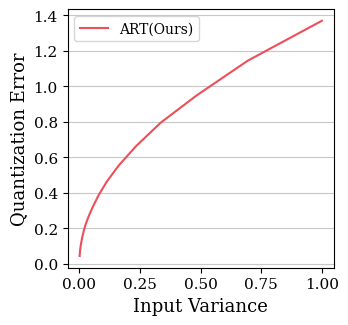

In [131]:
ratio = 0.8
plt.figure(figsize=(4.5*ratio, 4.5*ratio))  # Nature single-column width
# Draw line plot with std
_vars = _vars.cpu()
# plt.plot(_vars.numpy(), _errs["SINT4"], color="gray", markersize=4, label="SINT4", linestyle='dashed')
# plt.fill_between(_vars.numpy(), np.subtract(_errs["SINT4"], _stds["SINT4"]), np.add(_errs["SINT4"], _stds["SINT4"]), alpha=0.2, color=emrld[3])
plt.plot(_vars.numpy(), _errs["ART"], color=oryel[6], markersize=4, label="ART(Ours)")
# plt.fill_between(_vars.numpy(), np.subtract(_errs["ART"], _stds["ART"]), np.add(_errs["ART"], _stds["ART"]), alpha=0.2, color=oryel[3])
# plt.fill_between(_vars.numpy(), _errs["ART"], _errs["SINT4"], color=oryel[5], alpha=0.2)
plt.xlabel("Input Variance")
plt.ylabel("Quantization Error")
plt.grid(axis='y', alpha=0.7)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figs/quant_error_vs_input_variance_art_sint4.png", dpi=300)

In [61]:
_, quant_err, _, _= art(x, debug=True)
_, quant_err_sint4 = sint4(x, debug=True)

# Average quantization error vs absolute value
n_bins = 16
x_bins = np.linspace(0, x.abs().max().item(), n_bins + 1)
x_bin_centers = 0.5 * (x_bins[:-1] + x_bins[1:])

q_err_sint4 = []
q_err_art = []
for s, e in zip(x_bins[:-1], x_bins[1:]):
    mask = (x.abs() >= s) & (x.abs() < e)
    if mask.sum().item() == 0:
        q_err_art.append(0.0)
        q_err_sint4.append(0.0)
        continue
    err = quant_err[mask]
    q_err_art.append(err.norm(p='fro').item())#  / err.numel())
    err = quant_err_sint4[mask]
    q_err_sint4.append(err.norm(p='fro').item())# / err.numel())

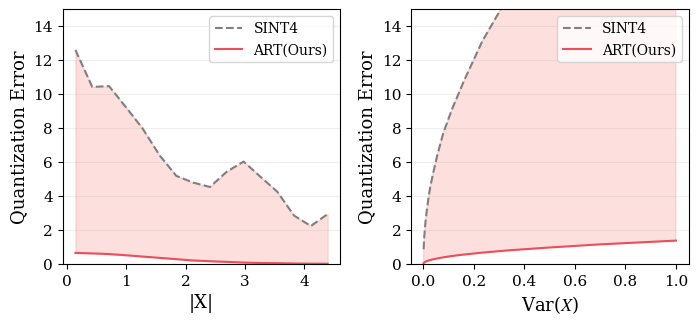

In [124]:
oryel = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
emrld = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]

ratio = 0.8
fig, axs = plt.subplots(1, 2, figsize=(9*ratio, 4.5*ratio))  # Nature single-column width
axs[0].plot(x_bin_centers, q_err_sint4, color="gray", label="SINT4", linestyle="--", markersize=4)
axs[0].plot(x_bin_centers, q_err_art, color=oryel[6], label="ART(Ours)")
axs[0].fill_between(x_bin_centers, q_err_art, q_err_sint4, color=oryel[5], alpha=0.2)
# axs[1].bar(x_bin_centers, q_err_art, color=oryel[6], label="ART(Ours)")
# plt.yscale("log")
axs[0].set_xlabel("|X|")
axs[0].set_ylabel("Quantization Error")
axs[0].grid(axis="y", alpha=0.2)
axs[0].legend(loc='upper right', fontsize='small')

axs[1].plot(_vars.numpy(), _errs["SINT4"], color="gray", markersize=4, linestyle='dashed', label="SINT4")
# plt.fill_between(_vars.numpy(), np.subtract(_errs["SINT4"], _stds["SINT4"]), np.add(_errs["SINT4"], _stds["SINT4"]), alpha=0.2, color=emrld[3])
axs[1].plot(_vars.numpy(), _errs["ART"], color=oryel[6], markersize=4, label="ART(Ours)")
# plt.fill_between(_vars.numpy(), np.subtract(_errs["ART"], _stds["ART"]), np.add(_errs["ART"], _stds["ART"]), alpha=0.2, color=oryel[3])
axs[1].fill_between(_vars.numpy(), _errs["ART"], _errs["SINT4"], color=oryel[5], alpha=0.2)
axs[1].set_xlabel("Var($X$)")
axs[1].set_ylabel("Quantization Error")
axs[1].grid(axis="y", alpha=0.2)
axs[1].legend(loc='upper right', fontsize='small')
axs[0].set_ylim(0, 15)
axs[1].set_ylim(0, 15)
# axs[1].legend(loc='upper right', fontsize='small')
# axs.set_ylim(0, 10)
# Create shared label
# fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figs/quant_error_with_art_vs_int4.png", dpi=300)

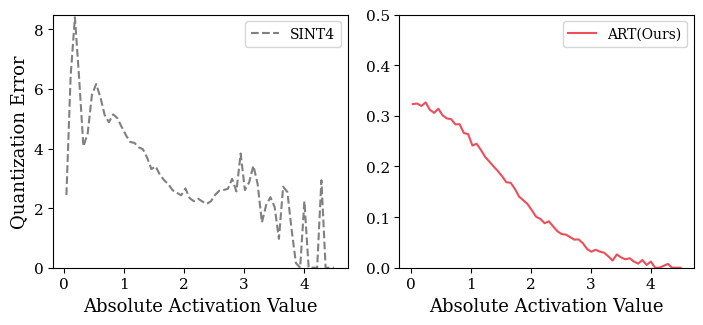

In [52]:
oryel = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
emrld = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]

ratio = 0.8
fig, axs = plt.subplots(1, 2, figsize=(9*ratio, 4.5*ratio))  # Nature single-column width
axs[0].plot(x_bin_centers, q_err_sint4, color="gray", label="SINT4", linestyle="--")
axs[1].plot(x_bin_centers, q_err_art, color=oryel[6], label="ART(Ours)")
# axs[0].fill_between(x_bin_centers, q_err_art, q_err_sint4, color=oryel[5], alpha=0.2)
# axs[1].bar(x_bin_centers, q_err_art, color=oryel[6], label="ART(Ours)")
# plt.yscale("log")
axs[0].set_xlabel("Absolute Activation Value")
axs[0].set_ylabel("Quantization Error")
axs[0].legend(loc='upper right', fontsize='small')
axs[0].set_ylim(0, 8.5)
axs[1].set_xlabel("Absolute Activation Value")
# axs[0].set_ylabel("Quantization Error")
axs[1].legend(loc='upper right', fontsize='small')
axs[1].set_ylim(0, 0.5)
# axs[1].legend(loc='upper right', fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("figs/avg_quant_error_vs_abs_activation_art_v2.png", dpi=300)

In [ ]:
# Flatten input activation ([2, 4096, 1152]) by input channels : [2*4096, 1152]
flat_x = x.view(-1, x.shape[-1]).to(torch.float32)
flat_sm_x = sm_x.view(-1, sm_x.shape[-1]).to(torch.float32)
flat_x.quantile(0.99, dim=0), flat_x.amax(dim=0), flat_sm_x.quantile(0.99, dim=0), flat_sm_x.amax(dim=0)

In [ ]:
# Draw a combined plot with two different y-axis for each q_error and var_error
fig, ax1 = plt.subplots(figsize=(6.8, 4.2))
ax2 = ax1.twinx()
ax1.plot(alphas, q_errors, marker='o', markersize=4, color='tab:blue', label="Q_Error")
ax2.plot(alphas, errors, marker='o', markersize=4, color='tab:orange', label="Var_Err")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Quantization Error", color='tab:blue')
ax2.set_ylabel("Variance Error", color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
fig.tight_layout()
plt.title("Quantization and Variance Error vs Alpha for QuaRTZ + SINT4")
plt.show()

In [ ]:
# sm_x, sm_w = apply_smoothing(x, w, scale=b_s)
dequant_x, quant_err, artlab_err, comp_err = art(sm_x, debug=True)
comp_err_norm = torch.norm(comp_err, p='fro').item()
quant_err_norm = torch.norm(quant_err, p='fro').item()
artlab_err_norm = torch.norm(artlab_err, p='fro').item()
print(f"Comp Error Norm: {comp_err_norm:.4f}, Quant Error Norm: {quant_err_norm:.4f}, Artlab Error Norm: {artlab_err_norm:.4f}")

# SINT8 - S-ART Comp Error Norm: 16784.0000, Quant Error Norm: 187.8750, Artlab Error Norm: 219.1250
# UINT8 - S-ART Comp Error Norm: 16640.0000, Quant Error Norm: 4.6367, Artlab Error Norm: 86.1875
# CINT8 - S-ART Comp Error Norm: 12912.0000, Quant Error Norm: 9.0938, Artlab Error Norm: 123.0000
# UINT8 - U-ART Comp Error Norm: 14272.0000, Quant Error Norm: 4.6367, Artlab Error Norm: 70.8750
# UINT8(32) - U-ART Comp Error Norm: 15720.0000, Quant Error Norm: 3.5059, Artlab Error Norm: 60.0625

In [ ]:
# per_block_var = x.var(dim=1, unbiased=False)
# per_subblock_var = x.view(-1, 16).var(dim=1, unbiased=False)
per_block_var = sm_x.var(dim=1, unbiased=False)[0]
per_subblock_var = sm_x.view(-1, 16).var(dim=1, unbiased=False)[0]
per_block_quant_error = torch.norm(comp_err, p='fro', dim=1)[0]
per_block_artlab_error = torch.norm(artlab_err, p='fro', dim=1)[0]
per_block_comp_error = torch.norm(comp_err.view(-1, 16), p='fro', dim=1)[0]

In [ ]:
# Draw three boxplots in single row, 3 columns. Each boxplot shows per-block variance vs per-block error (quantization, artlab, compression)
import pandas as pd

def plot_err_box(ax, vars_, errs_, n_bins=30, title="", use_abs_error=True):
    var_bins = np.linspace(vars_.min(), vars_.max(), n_bins + 1)
    bin_labels = 0.5 * (var_bins[:-1] + var_bins[1:])

    df = pd.DataFrame({"var": vars_, "err": errs_})
    df["var_bin"] = pd.cut(df["var"], bins=var_bins, include_lowest=True, labels=bin_labels)

    groups = df.dropna().groupby("var_bin")["err"]
    data = [g.values for _, g in groups]
    x = [float(k) for k, _ in groups]

    if not data:
        ax.set_title(title + " (no data)")
        return

    ax.boxplot(
        data,
        positions=x,
        widths=(var_bins[1] - var_bins[0]) * 0.6,
        showfliers=False,
        manage_ticks=False,
    )
    means = [np.mean(d) for d in data]
    ax.plot(x, means, "o", color="tomato", markersize=3, label="Mean")

    ax.set_title(title)
    ax.set_xlabel("Per-Group Variance (binned)")
    ax.set_ylabel("Per-Group Quantization Error")

    # Density overlay of number of groups per bin
    counts = [len(d) for d in data]
    ax2 = ax.twinx()
    ax2.bar(
        x,
        counts,
        width=(var_bins[1] - var_bins[0]) * 0.6,
        color="gray",
        alpha=0.2,
        label="Count per bin",
    )
    ax2.set_ylabel("Count")
    ax2.set_ylim(0, max(counts) * 1.1)
    max_i = int(np.argmax(counts))
    ax2.text(x[max_i], counts[max_i], "max", ha="center", va="bottom", fontsize=8)

    # # CDF of error mass across variance bins
    # errs_for_mass = df["err"].abs() if use_abs_error else df["err"]
    # mass_by_bin = (
    #     df.assign(err_mass=errs_for_mass)
    #       .dropna()
    #       .groupby("var_bin")["err_mass"]
    #       .sum()
    # )
    # mass = mass_by_bin.values
    # if mass.sum() > 0:
    #     ax2 = ax.twinx()
    #     # cdf = np.cumsum(mass) / np.sum(mass)
    #     # ax2.plot(x, cdf, color="slateblue", linewidth=2, label="Error CDF")
    #     pdf = mass / mass.sum()
    #     ax2.plot(x, pdf, color="gray", linewidth=1, linestyle="--", label="Error PDF")
    #     ax2.set_ylim(0, 1)
    #     ax2.set_ylabel("PDF of total quantization error")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
# plot_err_box(axes[0], per_block_var.float().cpu().numpy(), per_block_quant_error.float().cpu().numpy(), n_bins=30, title="Quantization Error")
plot_err_box(axes[0], per_block_var.float().cpu().numpy(), per_block_artlab_error.float().cpu().numpy(), n_bins=30, title="Artlab Error")
plot_err_box(axes[1], per_subblock_var.float().cpu().numpy(), per_block_comp_error.float().cpu().numpy(), n_bins=30, title="Compression Error")
fig.suptitle(f"Error vs Variance (Quant Err={quant_err_norm:.4f}, Artlab Err={artlab_err_norm:.4f}, Comp Err={comp_err_norm:.4f})", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"figs/var_err_box_uint8_g{group_size}_art_g16.png", dpi=300)

In [ ]:
# plot_err_box(axes[0], per_block_var.float().cpu().numpy(), per_block_artlab_error.float().cpu().numpy(), n_bins=30, title="Artlab Error")
sm_x.shape

In [3]:
x_t = torch.stack([x[0] for x in xt])

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import PolyCollection

assert x_t.ndim == 3
T = x_t.shape[-1]

x_flat = x_t.permute(2, 0, 1).reshape(T, -1).detach().float().cpu().numpy()

lo, hi = np.quantile(x_flat, [0.001, 0.999])
num_bins = 256
bin_edges = np.linspace(lo, hi, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

dens = []
for t in range(T):
    h, _ = np.histogram(x_flat[t], bins=bin_edges, density=True)
    dens.append(h)

# Build polygons in the (x,z) plane; Matplotlib will place them at y=t
verts = []
for t in range(T):
    z = dens[t]
    # polygon: start at left baseline -> along curve -> end at right baseline -> close
    verts.append([(bin_centers[0], 0.0), *list(zip(bin_centers, z)), (bin_centers[-1], 0.0)])

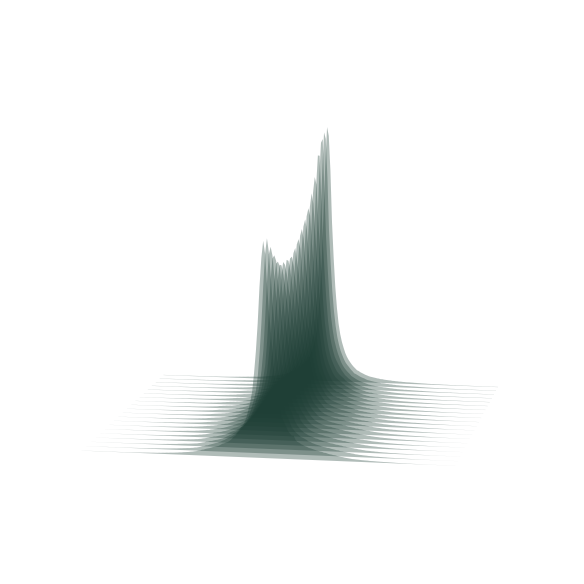

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

num_channel = 256
poly = PolyCollection(verts[:num_channel], alpha=0.35)  # no explicit colors (per your usual preference)
ax.add_collection3d(poly, zs=np.arange(num_channel), zdir="y")

ax.set_xlim(lo, hi)
ax.set_ylim(0, T - 1)
ax.set_zlim(0, max(map(np.max, dens)))

ax.set_xlabel("Value (dynamic range)")
ax.set_ylabel("Input Channels")
ax.view_init(elev=10, azim=100)
ax.axis(yaxis='off')

plt.tight_layout()
plt.show()

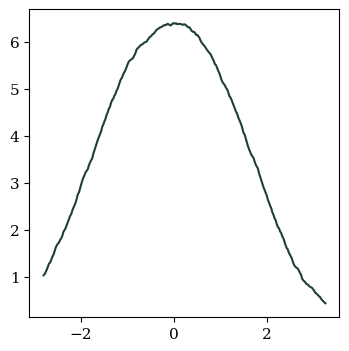

In [6]:
tmp = torch.randn(1024).numpy()
hist, bins = np.histogram(tmp, bins=256)

# Smooth hist
hist = np.convolve(hist, np.ones(150)/150, mode='same')

plt.figure(figsize=(4,4))
plt.plot(bins[:-1], hist)
plt.show()

In [193]:
"""
3D bound visualization (Idea 1): tail mass × truncation severity → ART total upper bound
-----------------------------------------------------------------------------
Axes:
  x: p_tail  = P(M >= 8)  (mass in truncated region)
  y: c       = E[2^{H-3}-1 | H>=4]  (avg truncation severity, in [1, 15])
  z: E_total_ub/s8 = 0.5 + c * p_tail

Also overlays the SINT4 upper-bound plane:  E_q^4/s8 = 8
Optionally overlays an empirical point computed from data x.

Assumptions (adjust if your implementation differs):
  - int8 step: s8 = max(|x|)/127  (symmetric signed int8, midtread-ish)
  - magnitude index: m = round(|x|/s8) clipped to [0,127]
"""

from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from typing import List

try:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
except Exception:
    pass


# ----------------------------
# Utilities for empirical (p_tail, c)
# ----------------------------
def bitlen_magnitude(m: np.ndarray) -> np.ndarray:
    """
    H(m) =
      0 if m == 0
      floor(log2(m))+1 if m >= 1
    """
    m = m.astype(np.int64)
    H = np.zeros_like(m, dtype=np.int64)
    nz = m > 0
    H[nz] = (np.floor(np.log2(m[nz])).astype(np.int64) + 1)
    return H


@dataclass
class EmpiricalStats:
    s8: List[float]
    p_tail: List[float]
    c: List[float]
    z_ub: List[float]

def compute_art_coords_per_block(x_blocks):
    """
    x_blocks: list or iterable of np.ndarray (each block)
    """
    pts = []
    for xb in x_blocks:
        stats = compute_empirical_stats(xb)
        pts.append((stats.p_tail, stats.c, stats.z_ub))
    return np.array(pts)  # shape [B, 3]

def compute_empirical_stats(x: np.ndarray, eps: float = 1e-12) -> EmpiricalStats:
    x = np.asarray(x, dtype=np.float64) # [Num_Groups, 64]
    max_abs = float(np.max(np.abs(x)))
    s8 = np.maximum(max_abs / 127.0, eps)

    # magnitude indices on the 8-bit grid (rounded to nearest int8 code magnitude)
    m = np.rint(np.abs(x) / s8).astype(np.int64)
    m = np.clip(m, 0, 127)

    H = bitlen_magnitude(m)

    tail = (m >= 8)
    p_tail = np.mean(tail)

    trunc = (H >= 4)
    if np.any(trunc):
        # per-sample truncation severity weight: (2^{H-3}-1), valid for H>=4
        w = (2.0 ** (H[trunc] - 3) - 1.0)
        c = float(np.mean(w))  # conditional mean over truncation region
    else:
        c = 1.0  # arbitrary; it won't matter since p_tail will be 0 in typical cases

    # normalized upper bound surface value at (p_tail, c)
    z_ub = 0.5 + c * p_tail
    return EmpiricalStats(s8=s8, p_tail=p_tail, c=c, z_ub=z_ub)


# ----------------------------
# Main plotting
# ----------------------------
def plot_bound_surface(
    n_p: int = 80,
    n_c: int = 80,
    add_empirical_point: bool = False,
    empirical_x: np.ndarray | None = None,
    out_path: str | None = None,
):
    # Grid
    p = np.linspace(0.0, 1.0, n_p)          # p_tail
    c = np.linspace(1.0, 15.0, n_c)         # trunc severity
    P, C = np.meshgrid(p, c, indexing="xy")

    # ART total upper bound (normalized by s8)
    Z_art = 0.5 + C * P

    # SINT4 upper bound plane (normalized by s8): s4/2 = 8*s8
    Z_sint4 = np.full_like(Z_art, 8.0)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    # Surface: ART bound
    surf = ax.plot_surface(P, C, Z_art, rstride=1, cstride=1, linewidth=0, antialiased=True)

    # Plane: SINT4 bound
    plane = ax.plot_surface(P, C, Z_sint4, rstride=1, cstride=1, linewidth=0, alpha=0.25, antialiased=True)

    # Optional empirical point from data
    if add_empirical_point:
        if empirical_x is None:
            raise ValueError("add_empirical_point=True requires empirical_x array.")
        stats = compute_empirical_stats(empirical_x)

        ax.scatter(
            [stats.p_tail],
            [stats.c],
            [stats.z_ub],
            s=60,
            marker="o",
            depthshade=True,
            label=f"Empirical (p={stats.p_tail:.3f}, c={stats.c:.2f})",
        )

        # Annotate
        ax.text(
            stats.p_tail,
            stats.c,
            stats.z_ub,
            f"  z={stats.z_ub:.2f}",
            fontsize=10,
        )
        print(
            f"[empirical] s8={stats.s8:.6g}, p_tail={stats.p_tail:.6g}, c={stats.c:.6g}, "
            f"z_ub=E_total_ub/s8={stats.z_ub:.6g} (SINT4 plane at 8)"
        )

    ax.set_xlabel(r"$p_{\ge 8}=\mathbb{P}(M\ge 8)$")
    ax.set_ylabel(r"$c=\mathbb{E}[2^{H-3}-1 \mid H\ge 4]$")
    ax.set_zlabel(r"Upper bound normalized by $s_8$")

    ax.set_title("ART Total Upper Bound Surface vs. SINT4 Upper-Bound Plane")

    # Nice view
    ax.view_init(elev=25, azim=-60)

    # Z limits to keep plane visible
    ax.set_zlim(0.0, max(10.0, float(np.max(Z_art))))

    # Add a colorbar for the ART surface (optional but useful)
    fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.08, label=r"$\frac{E^{ART}_{total,ub}}{s_8}$")

    # Legend only if empirical point added
    if add_empirical_point:
        ax.legend(loc="upper left")

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()


def plot_art_vs_sint4_bound_surface(x = None, n_p=80, n_c=80, out_path=None):
    # Grid: p_tail in [0,1], c in [1,15]
    p = np.linspace(0.0, 1.0, n_p)
    c = np.linspace(1.0, 15.0, n_c)
    P, C = np.meshgrid(p, c, indexing="xy")

    # ART total upper bound normalized by s8: z = 0.5 + c * p_tail
    Z_art = 0.5 + C * P

    # SINT4 upper bound plane normalized by s8: 8
    Z_sint4 = np.full_like(Z_art, 8.0)

    mask_above = Z_art > Z_sint4
    mask_below = ~mask_above

    Z_art_above = np.ma.masked_where(~mask_above, Z_art)
    Z_art_below = np.ma.masked_where(~mask_below, Z_art)

    # --- Color templates ---
    template_1 = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
    template_2 = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]
    template_3 = ["#C8C8C3","#1B5C54","#CC4633","#E06E52"]

    # Build colormap (recommended: template_2)
    art_cmap = LinearSegmentedColormap.from_list(
        "ART_bound",
        template_2,
        N=256
    )

    # stats = compute_empirical_stats(x) if x is not None else None
    x_blocks = [item.cpu().numpy() for item in x]
    pts = compute_art_coords_per_block(x_blocks)

    fig = plt.figure(figsize=(4.5, 4.5))  # Nature single-column width
    ax = fig.add_subplot(111, projection="3d")

    # --- ART surface ---
    # surf = ax.plot_surface(
    #     P, C, Z_art,
    #     cmap=art_cmap,
    #     linewidth=0,
    #     antialiased=True,
    #     alpha=0.95
    # )
    ax.plot_surface(
        P, C, Z_art_below,
        cmap=art_cmap,
        linewidth=0,
        antialiased=True,
        alpha=0.85
    )

    # ART surface ABOVE SINT4 (stronger / more opaque)
    ax.plot_surface(
        P, C, Z_art_above,
        cmap=art_cmap,
        linewidth=0,
        antialiased=True,
        alpha=0.35
    )

    # --- SINT4 plane (neutral, unobtrusive) ---
    ax.plot_surface(
        P, C, Z_sint4,
        color=template_1[2],   # from template_3 (neutral gray)
        alpha=0.35,
        linewidth=0
    )
    
    # Boundary curve where ART bound == SINT4 bound:
    # 0.5 + c * p = 8  -> p = 7.5 / c
    c_curve = np.linspace(1.0, 15.0, 400)
    p_curve = 7.5 / c_curve
    p_curve = np.clip(p_curve, 0.0, 1.0)
    z_curve = np.full_like(p_curve, 8.0)

    # --- Boundary curve: ART = SINT4 ---
    ax.plot(
        p_curve,
        c_curve,
        z_curve,
        color="#1a1a1a",
        linewidth=2.5,
        # label="ART = SINT4 bound"
    )
    
    if pts is not None:

        ax.scatter(
            pts[:, 0], pts[:, 1], pts[:, 2],
            s=35,
            color="#1a1a1a",
            alpha=0.6,
            depthshade=True,
            zorder=10
        )
        # ax.scatter(
        #     stats.p_tail,
        #     stats.c,
        #     stats.z_ub,
        #     s=80,
        #     marker="o",
        #     color="black",
        #     depthshade=True,
        #     zorder=10,
        # )

        # err_art = np.linalg.norm(x - art(x)) / stats.s8
        # err_s4  = np.linalg.norm(x - sint4(x)) / stats.s8

        # ax.scatter(stats.p_tail, stats.c, err_art,
        #         marker="^", s=70, color="#074050", zorder=11)

        # ax.scatter(stats.p_tail, stats.c, err_s4,
        #         marker="s", s=70, color="#ee4d5a", zorder=11)

    # --- Colorbar ---
    # cbar = fig.colorbar(
    #     surf,
    #     ax=ax,
    #     shrink=0.65,
    #     pad=0.08
    # )
    # cbar.set_label(r"$E^{\mathrm{ART}}_{\mathrm{total,ub}} / s_8$")

    # Labels (mathtext-safe: use \geq, use \mathrm{Pr})
    # ax.set_xlabel(r"$p_{\geq 8}=\mathrm{Pr}(M\geq 8)$")
    # ax.set_ylabel(r"$c=\mathbb{E}[2^{H-3}-1 \mid H\geq 4]$")
    # ax.set_zlabel(r"Upper bound normalized by $s_8$")
    ax.set_xlabel(r"$P_{\text{tail}}(X)$")
    ax.set_ylabel("Truncation Severity")
    ax.set_zlabel("Quantization Error")

    # ax.set_title("ART Total Upper Bound Surface vs. SINT4 Upper-Bound Plane")
    legend_handles = [
        Patch(facecolor=template_2[-1], edgecolor="none", label="ART surface"),
        Patch(facecolor=template_1[2], edgecolor="none", label="SINT4 plane"),
    ]

    fig.legend(
        handles=legend_handles,
        loc="lower center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, -0.05)
    )

    plt.subplots_adjust(bottom=0.18)

    # View
    ax.view_init(elev=25, azim=-120)

    # Reasonable z-limits
    ax.set_zlim(0.0, max(10.0, float(np.max(Z_art))))

    # Colorbar for ART surface
    # fig.colorbar(surf, ax=ax, shrink=0.65, pad=0.08,
    #              label=r"$E^{\mathrm{ART}}_{\mathrm{total,ub}}/s_8$")

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    # ax.zaxis.pane.fill = False
    ax.set_box_aspect((1.2, 1.0, 0.7))

    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, dpi=200, bbox_inches="tight", pad_inches=1)
    plt.show()


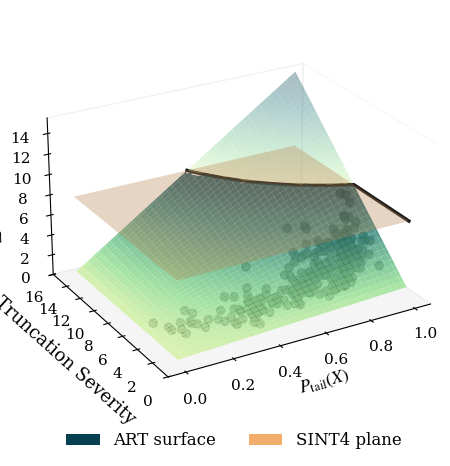

In [197]:
x_sample = x.view(-1, 64)[:256]
n_p = 80
n_c = 80
out = "figs/art_bound_surface.png"
plot_art_vs_sint4_bound_surface(x_sample, n_p, n_c, out_path=out)

In [190]:
import torch

# Pixart Sigma
activations = torch.load("extractions/activations.pt")
print(activations.keys())
# layer = "ff.net.0.proj"
layer = "attn1.to_q"
xt = activations[f'transformer_blocks.0.{layer}']
x = xt[0][0].float()

dict_keys(['transformer_blocks.0.attn1.to_q', 'transformer_blocks.0.attn1.to_k', 'transformer_blocks.0.attn1.to_v', 'transformer_blocks.0.attn1.to_out.0', 'transformer_blocks.0.attn2.to_q', 'transformer_blocks.0.attn2.to_k', 'transformer_blocks.0.attn2.to_v', 'transformer_blocks.0.attn2.to_out.0', 'transformer_blocks.0.ff.net.0.proj', 'transformer_blocks.0.ff.net.2'])


In [81]:
nx = torch.abs(x)
x_4 = torch.abs(sint4(x))
x_art = torch.abs(art(x))

In [82]:
# Sample 1024 activations
num_samples = 1024
idx = torch.randperm(x.numel())[:num_samples]
nx = nx.view(-1)[idx]
x_sint4 = x_4.view(-1)[idx]
x_art = x_art.view(-1)[idx]

In [118]:
nx_hist, bins = torch.histogram(nx, bins=256, density=True)
sint4_hist, _ = torch.histogram(x_sint4, bins=bins, density=True)
art_hist, _ = torch.histogram(x_art, bins=bins, density=True)

sin4_err = abs(nx_hist - sint4_hist)
art_err = abs(nx_hist - art_hist)

sin4_err = np.convolve(sin4_err.cpu().numpy(), np.ones(5)/5, mode='same')
art_err = np.convolve(art_err.cpu().numpy(), np.ones(5)/5, mode='same')

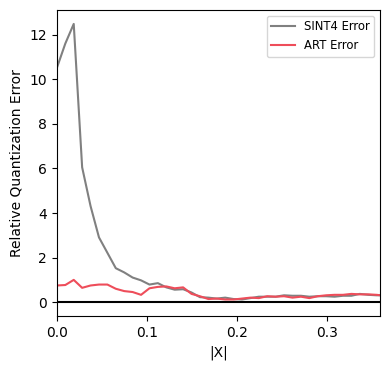

In [119]:
plt.figure(figsize=(4,4))
plt.plot(bins[:-1].cpu().numpy(), sin4_err, label='SINT4 Error', color='gray')
# plt.fill_between(bins[:-1].cpu().numpy(), sin4_err.cpu().numpy(), 0, color='blue', alpha=0.3)
# plt.fill_between(bins[:-1].cpu().numpy(), sin4_err, 0, where=(sin4_err < 0), color='blue', alpha=0.1)
plt.plot(bins[:-1].cpu().numpy(), art_err, label='ART Error', color='#ee4d5a')
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)
plt.xlabel("|X|")
plt.ylabel("Relative Quantization Error")
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(0, nx.max().item()*0.15)
plt.show()

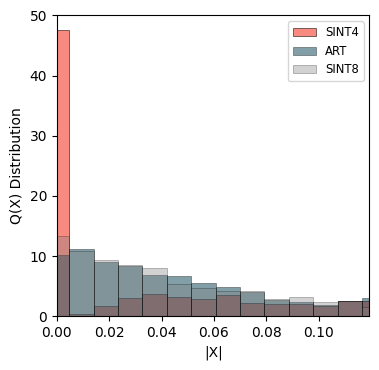

In [151]:
template_1 = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
template_2 = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]
template_3 = ["#C8C8C3","#1B5C54","#CC4633","#E06E52"]
plt.figure(figsize=(4,4))
plt.bar(bins[:-1].cpu().numpy(), sint4_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=0.75, label='SINT4', color=template_1[5], edgecolor='black', linewidth=0.5)
plt.bar(bins[:-1].cpu().numpy(), art_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=0.5, label='ART', color=template_2[6], edgecolor='black', linewidth=0.5)
plt.bar(bins[:-1].cpu().numpy(), nx_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=0.35, label='SINT8', color='gray', edgecolor='black', linewidth=0.5)
plt.xlabel("|X|")
plt.ylabel("Q(X) Distribution")
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(0, nx.max().item()*0.05)
plt.show()

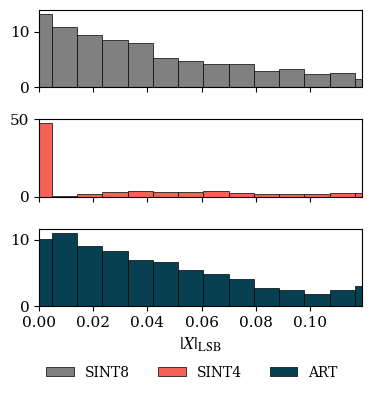

In [199]:
fig, axs = plt.subplots(3, 1, figsize=(4, 4), sharex=True)
axs[0].bar(bins[:-1].cpu().numpy(), nx_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=1, label='SINT8', color='gray', edgecolor='black', linewidth=0.5)
axs[1].bar(bins[:-1].cpu().numpy(), sint4_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=1, label='SINT4', color=template_1[5], edgecolor='black', linewidth=0.5)
axs[2].bar(bins[:-1].cpu().numpy(), art_hist.cpu().numpy(), width=(bins[1]-bins[0]).cpu().numpy(), alpha=1, label='ART', color=template_2[6], edgecolor='black', linewidth=0.5)
# show legend below entire subplots
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False, fontsize='small')
plt.xlabel("$|X|_{\\text{LSB}}$")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(0, nx.max().item()*0.05)
plt.savefig("figs/quantized_activation_distribution_art_vs_int4.png", dpi=200, bbox_inches='tight', pad_inches=5)

In [171]:
def compute_art_coordinates_from_x(x: np.ndarray, eps=1e-12):
    """
    Given real activations x, compute:
      - p_tail : fraction of values that will be truncated by ART (m >= 8)
      - c      : average truncation severity among truncated values
      - z_ub   : ART total upper bound (normalized by s8)
    """
    x = np.asarray(x).ravel()

    # signed int8 step (consistent with your derivation)
    s8 = max(np.max(np.abs(x)) / 127.0, eps)

    # magnitude index on int8 grid
    m = np.rint(np.abs(x) / s8).astype(np.int64)
    m = np.clip(m, 0, 127)

    # bit-length H(m)
    H = np.zeros_like(m)
    nz = m > 0
    H[nz] = np.floor(np.log2(m[nz])).astype(int) + 1

    # truncation mask: H >= 4  <=>  m >= 8
    trunc = m >= 8
    p_tail = trunc.mean()

    if trunc.any():
        severity = (2 ** (H[trunc] - 3) - 1)
        c = severity.mean()
    else:
        c = 1.0  # irrelevant if p_tail = 0

    # ART total upper bound (normalized by s8)
    z_ub = 0.5 + c * p_tail

    return dict(
        s8=s8,
        p_tail=p_tail,
        c=c,
        z_ub=z_ub,
    )

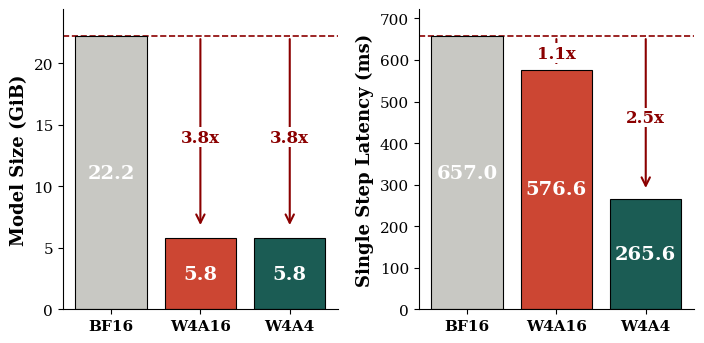

In [31]:
# Data
x_range = [0, 1, 2]
model_size = [22.2, 5.8, 5.8]
# inf_mem = [24.4, 17.9, 15.7]
latency = [657.0, 576.6, 265.6]
imprv = [["3.8x", "3.8x"], ["1.1x", "2.5x"]]
labels = ["BF16", "W4A16", "W4A4"]
cmaps = ["#C8C8C3", "#CC4633", "#1B5C54"]

# Setup subplots
ratio = 0.8
fig, axs = plt.subplots(1, 2, figsize=(9*ratio, 4.5*ratio))
data_list = [model_size, latency]
titles = ["Model Size (GiB)", "Single Step Latency (ms)"]

for i, data in enumerate(data_list):
    # Plot bars and reference line
    bars = axs[i].bar(x_range, data, color=cmaps, edgecolor='black', linewidth=0.8)
    axs[i].axhline(data[0], color='#8B0000', linestyle='--', linewidth=1.2, zorder=0)
    
    # --- KEY CHANGE: Place labels INSIDE with WHITE text ---
    axs[i].bar_label(bars, fmt='%.1f', label_type='center', color='white', fontweight='bold', fontsize=14)
    
    # Draw Improvement Arrows
    for idx, x_pos in enumerate([1, 2]):
        start_y = data[0]
        end_y = data[x_pos]
        
        axs[i].annotate('', xy=(x_pos, end_y + (start_y-end_y)*0.05), xytext=(x_pos, start_y),
                        arrowprops=dict(arrowstyle='->', color='#8B0000', lw=1.5, mutation_scale=15))
        
        axs[i].text(x_pos, (start_y + end_y) / 2, imprv[i][idx], 
                    color='#8B0000', fontweight='bold', fontsize=12, 
                    ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', pad=1))

    # Formatting
    axs[i].set_xticks(x_range)
    axs[i].set_xticklabels(labels, fontweight='bold')
    axs[i].set_ylabel(titles[i], fontweight='bold')
    axs[i].set_ylim(0, max(data) * 1.1)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('artlab_efficiency_plot.png')
plt.show()

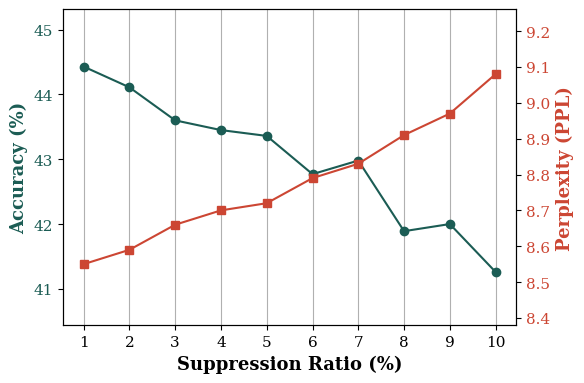

In [28]:
_tmp = """
Task: Arc_challenge, PPL: WIkitext2
baseline: 44.79 (8.51) (양자화한 형태의 baseline)
1%: 44.43 (8.55)  Performance Drop Rate: (0.803%/0.468%)
2%: 44.11 (8.59)  Performance Drop Rate: (1.518%/0.931%)
3%: 43.60 (8.66)  Performance Drop Rate: (2.65%/1.73%)
4%: 43.45 (8.70)  Performance Drop Rate: (2.99%/2.18%)
5%: 43.36 (8.72)  Performance Drop Rate: (3.19%/2.41%)
6%: 42.77 (8.79)  Performance Drop Rate: (4.50%/3.18%)
7%: 42.98 (8.83)  Performance Drop Rate: (4.04%/3.62%)
8%: 41.89 (8.91)  Performance Drop Rate: (6.47%/4.48%)
9%: 42.00 (8.97)  Performance Drop Rate: (6.23%/5.12%)
10%: 41.26 (9.08) Performance Drop Rate: (7.88%/6.27%)  
"""

ratio = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
acc = [44.43, 44.11, 43.60, 43.45, 43.36, 42.77, 42.98, 41.89, 42.00, 41.26]
ppl = [8.55, 8.59, 8.66, 8.70, 8.72, 8.79, 8.83, 8.91, 8.97, 9.08]
acc_drop_rate = [0.803, 1.518, 2.65, 2.99, 3.19, 4.50, 4.04, 6.47, 6.23, 7.88]
ppl_drop_rate = [0.468, 0.931, 1.73, 2.18, 2.41, 3.18, 3.62, 4.48, 5.12, 6.27]

# Draw two line plots (accuracy and ppl) with twin y-axes
fig, ax1 = plt.subplots(figsize=(6,4))
color_acc = '#1B5C54'
color_ppl = '#CC4633'
ax1.set_xlabel('Suppression Ratio (%)', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', color=color_acc, fontweight='bold')
ax1.plot(ratio, acc, marker='o', color=color_acc, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_xticks(ratio)
ax1.set_ylim(min(acc)*0.98, max(acc)*1.02)
ax1.grid(axis='x')
ax2 = ax1.twinx()
ax2.set_ylabel('Perplexity (PPL)', color=color_ppl, fontweight='bold')
ax2.plot(ratio, ppl, marker='s', color=color_ppl, label='PPL')
ax2.tick_params(axis='y', labelcolor=color_ppl)
ax2.set_ylim(min(ppl)*0.98, max(ppl)*1.02)
fig.tight_layout()
fig.savefig('llm_suppress.png', dpi=200, bbox_inches='tight')
plt.show()